In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import requests

In [2]:
tg_api_token = '5102696637:AAHcm9cOmIF7-GyG7nHHJYA_yZCGSWSTu60'
tg_chat_id = '1126129331'

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

In [3]:
def print_distributions_of_labels(labels_np):
    unique_values, counts = np.unique(labels_np, axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

# Models

In [4]:
f=open("input_model_data",'rb')
data=pickle.load(f,encoding='latin1')

In [5]:
features = data["trainning_data_features"]
targets = data["trainning_data_targets"]

In [6]:
features.shape, targets.shape

((528217, 630, 5), (528217,))

In [7]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
num_features = len(chest_signal_available)

In [8]:
win_size = (90*700)//100
step_slinding_window = 100

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU, GaussianNoise, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import convert_to_tensor

import datetime

## Preparing Data as Model Input Data

In [10]:
def remove_data(features, targets, label_id):
    indexes = np.where(targets == label_id)
    return np.delete(features, indexes, axis=0), np.delete(targets, indexes)

def update_labels(targets, old_label_id, new_label_id):
    '''baseline = 0, stress = 1, amusement = 2'''
    indexes = np.where(targets == old_label_id)
    targets[indexes] = new_label_id
    return targets

In [11]:
for label_id in [0, 4, 5]:
    features, targets = remove_data(features, targets, label_id)
print(features.shape, targets.shape)

for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    targets = update_labels(targets, old_label_id, new_label_id)
print(features.shape, targets.shape)
print_distributions_of_labels(targets)

(211115, 630, 5) (211115,)
(211115, 630, 5) (211115,)
[0 1 2] [113234  63210  34671]
[0 1 2] [0.5363617  0.29941027 0.16422803]


In [12]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(targets), y = targets)
weights = {i : weights[i] for i in range(len(weights))}
weights

{0: 0.6214711717917469, 1: 1.1132995833992512, 2: 2.029698210800573}

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, stratify=targets)

In [14]:
x_train.shape, x_test.shape

((126669, 630, 5), (84446, 630, 5))

In [15]:
y_train.shape, y_test.shape

((126669,), (84446,))

In [16]:
x_train_tensor = convert_to_tensor(x_train)
x_test_tensor = convert_to_tensor(x_test)
y_train_tensor = convert_to_tensor(y_train, dtype="int64")
y_test_tensor = convert_to_tensor(y_test, dtype="int64")

2022-02-14 19:05:59.618824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-14 19:05:59.929130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:41:00.0, compute capability: 7.5
2022-02-14 19:05:59.930525: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3192058800 exceeds 10% of free system memory.
2022-02-14 19:06:01.123607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2128039200 exceeds 10% of free system memory.


In [17]:
x_train_tensor.shape, x_test_tensor.shape

(TensorShape([126669, 630, 5]), TensorShape([84446, 630, 5]))

In [18]:
y_train_tensor.shape, y_test_tensor.shape

(TensorShape([126669]), TensorShape([84446]))

## Creation of Models to Test

In [19]:
num_classes = 3

In [20]:
num_classes, num_features

(3, 5)

In [21]:
def lstm(model = None):
    model.add(LSTM(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(num_classes, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(num_classes, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))

def lstm_baseline(model = None):
    model.add(LSTM(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Flatten())
    model.add(Dense(num_classes))
        
def gru_baseline(model = None):
    model.add(GRU(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Flatten())
    model.add(Dense(num_classes))
        

In [22]:
def generate_model_to_test(color_plot, layers, optimizer):
    return {
        "color_plot": color_plot,
        "layers": layers,
        "optimizer": optimizer,
        "callbacks": [
            TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5),
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min')
        ]
    }

In [23]:
models_to_test = {
    "softmax_lstm_adam": generate_model_to_test(color_plot="blue", layers=lstm, optimizer="adam"),
    "softmax_lstm_nadam": generate_model_to_test(color_plot="slateblue", layers=lstm, optimizer="nadam"),
    "softmax_lstm_rmsprop": generate_model_to_test(color_plot="blueviolet", layers=lstm, optimizer="rmsprop"),
    "softmax_gru_adam": generate_model_to_test(color_plot="red", layers=gru, optimizer="adam"),
    "softmax_gru_nadam": generate_model_to_test(color_plot="orangered", layers=gru, optimizer="nadam"),
    "softmax_gru_rmsprop": generate_model_to_test(color_plot="sienna", layers=gru, optimizer="rmsprop"),
    "softmax_lstm_baseline_adam": generate_model_to_test(color_plot="green", layers=lstm_baseline, optimizer="adam"),
    "softmax_lstm_baseline_nadam": generate_model_to_test(color_plot="lime", layers=lstm_baseline, optimizer="nadam"),
    "softmax_lstm_baseline_rmsprop": generate_model_to_test(color_plot="mediumaquamarine", layers=lstm_baseline, optimizer="rmsprop"),
    "softmax_gru_baseline_adam": generate_model_to_test(color_plot="gold", layers=gru_baseline, optimizer="adam"),
    "softmax_gru_baseline_nadam": generate_model_to_test(color_plot="yellow", layers=gru_baseline, optimizer="nadam"),
    "softmax_gru_baseline_rmsprop": generate_model_to_test(color_plot="darkkhaki", layers=gru_baseline, optimizer="rmsprop")
}

In [24]:
def create_model(hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    model.add(Activation("softmax"))
    
    model.build()
    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam or rmstrop
        metrics = ["sparse_categorical_accuracy", "accuracy"]
    )

    return model

In [25]:
history_list = {}

for model_name in models_to_test:

    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]
    
    send_tg_message(f"Começou a treinar o modelo: {model_name}.")

    model = create_model(hidden_layer, optimizer)
    history = model.fit(
        x=x_train_tensor,
        y=y_train_tensor,
        validation_data=(x_test_tensor, y_test_tensor),
        epochs=100,
        shuffle=False,
        class_weight=weights,
        callbacks=models_to_test[model_name]["callbacks"]
    )
    
    model.save(os.path.join("models", "1,5min-1sec-60percent-100pts", model_name))

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model
    
    history_list[model_name] = history
    
    with open("models_history", 'wb') as f:
        pickle.dump({"model_history": history_list }, f)
    
    send_tg_message(f"O modelo {model_name} terminou e foi salvo")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 630, 128)          68608     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 630, 128)          0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 630, 128)         0         
 se)                                                             
                                                                 
 dropout (Dropout)           (None, 630, 128)          0         
                                                                 
 flatten (Flatten)           (None, 80640)             0         
                                                                 
 dense (Dense)               (None, 3)                 241923    
                                                        

2022-01-31 11:26:12.757143: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3192058800 exceeds 10% of free system memory.


Epoch 1/100


2022-01-31 11:26:14.890894: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


3959/3959 [==============================] - ETA: 0s - loss: 4.3713 - sparse_categorical_accuracy: 0.5358 - accuracy: 0.5358

2022-01-31 11:28:02.261434: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2128039200 exceeds 10% of free system memory.


3959/3959 [==============================] - 140s 35ms/step - loss: 4.3713 - sparse_categorical_accuracy: 0.5358 - accuracy: 0.5358 - val_loss: 1.4167 - val_sparse_categorical_accuracy: 0.8241 - val_accuracy: 0.8241
Epoch 2/100
3959/3959 [==============================] - 137s 35ms/step - loss: 4.6672 - sparse_categorical_accuracy: 0.6838 - accuracy: 0.6838 - val_loss: 7.7384 - val_sparse_categorical_accuracy: 0.3532 - val_accuracy: 0.3532
Epoch 3/100
3959/3959 [==============================] - 138s 35ms/step - loss: 8.5316 - sparse_categorical_accuracy: 0.4965 - accuracy: 0.4965 - val_loss: 3.9320 - val_sparse_categorical_accuracy: 0.5016 - val_accuracy: 0.5016
Epoch 4/100
3959/3959 [==============================] - 137s 35ms/step - loss: 7.0950 - sparse_categorical_accuracy: 0.5625 - accuracy: 0.5625 - val_loss: 2.3225 - val_sparse_categorical_accuracy: 0.7414 - val_accuracy: 0.7414
Epoch 5/100
3959/3959 [==============================] - 137s 35ms/step - loss: 6.2447 - sparse_cate

2022-01-31 12:16:43.142264: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_adam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_adam/assets


INFO:tensorflow:Assets written to: ram://3cd8c6a0-9e73-4d3e-83ec-315f63c9a828/assets


INFO:tensorflow:Assets written to: ram://3cd8c6a0-9e73-4d3e-83ec-315f63c9a828/assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 630, 128)          68608     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 630, 128)         0         
 oise)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 630, 128)          0         
                                                                 
 flatten_1 (Flatten)         (None, 80640)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 241923    
                                                      

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_nadam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_nadam/assets


INFO:tensorflow:Assets written to: ram://00a89d58-002c-46b7-8de1-d189267a6ef4/assets


INFO:tensorflow:Assets written to: ram://00a89d58-002c-46b7-8de1-d189267a6ef4/assets


INFO:tensorflow:Assets written to: ram://0a8d8001-20c9-4051-9f3d-9f25cb6f603d/assets


INFO:tensorflow:Assets written to: ram://0a8d8001-20c9-4051-9f3d-9f25cb6f603d/assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 630, 128)          68608     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 gaussian_noise_2 (GaussianN  (None, 630, 128)         0         
 oise)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 630, 128)          0         
                                                                 
 flatten_2 (Flatten)         (None, 80640)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 241923    
                                                      

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_rmsprop/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_rmsprop/assets


INFO:tensorflow:Assets written to: ram://09744f54-ddc3-4bc2-9255-9e68409eadcc/assets


INFO:tensorflow:Assets written to: ram://09744f54-ddc3-4bc2-9255-9e68409eadcc/assets


INFO:tensorflow:Assets written to: ram://a490eb45-993c-42a7-89d3-4f1a86cf53c8/assets


INFO:tensorflow:Assets written to: ram://a490eb45-993c-42a7-89d3-4f1a86cf53c8/assets


INFO:tensorflow:Assets written to: ram://53bdcb4f-165e-4086-83f3-fb5ebde18859/assets


INFO:tensorflow:Assets written to: ram://53bdcb4f-165e-4086-83f3-fb5ebde18859/assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 gaussian_noise_3 (GaussianN  (None, 630, 128)         0         
 oise)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 630, 128)          0         
                                                                 
 flatten_3 (Flatten)         (None, 80640)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 241923    
                                                      

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_adam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_adam/assets


INFO:tensorflow:Assets written to: ram://1dcb3345-b624-4e4b-a33c-238d64343e66/assets


INFO:tensorflow:Assets written to: ram://1dcb3345-b624-4e4b-a33c-238d64343e66/assets


INFO:tensorflow:Assets written to: ram://939bbd50-8db0-4c9a-a3ee-db2283ae08ed/assets


INFO:tensorflow:Assets written to: ram://939bbd50-8db0-4c9a-a3ee-db2283ae08ed/assets


INFO:tensorflow:Assets written to: ram://a29c5df7-13b6-4aa4-8415-a4300dd53605/assets


INFO:tensorflow:Assets written to: ram://a29c5df7-13b6-4aa4-8415-a4300dd53605/assets


INFO:tensorflow:Assets written to: ram://da4bd8de-bed1-4465-9a1f-6f5326b9b1fa/assets


INFO:tensorflow:Assets written to: ram://da4bd8de-bed1-4465-9a1f-6f5326b9b1fa/assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 630, 128)         0         
 oise)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 630, 128)          0         
                                                                 
 flatten_4 (Flatten)         (None, 80640)             0         
                                                                 
 dense_4 (Dense)             (None, 3)                 241923    
                                                      

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_nadam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_nadam/assets


INFO:tensorflow:Assets written to: ram://05bda561-e9e3-4ad4-8643-517afdbebe2c/assets


INFO:tensorflow:Assets written to: ram://05bda561-e9e3-4ad4-8643-517afdbebe2c/assets


INFO:tensorflow:Assets written to: ram://e41e03e7-166f-421d-bd1e-bbe7ea2eecc8/assets


INFO:tensorflow:Assets written to: ram://e41e03e7-166f-421d-bd1e-bbe7ea2eecc8/assets


INFO:tensorflow:Assets written to: ram://181a18eb-e89d-4f5b-897f-7a257a1c155d/assets


INFO:tensorflow:Assets written to: ram://181a18eb-e89d-4f5b-897f-7a257a1c155d/assets


INFO:tensorflow:Assets written to: ram://4b8a2c46-27c3-4e74-a38a-70a067f16f84/assets


INFO:tensorflow:Assets written to: ram://4b8a2c46-27c3-4e74-a38a-70a067f16f84/assets


INFO:tensorflow:Assets written to: ram://ad0fd231-ac5a-40f6-835f-ac5a911fe370/assets


INFO:tensorflow:Assets written to: ram://ad0fd231-ac5a-40f6-835f-ac5a911fe370/assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 gaussian_noise_5 (GaussianN  (None, 630, 128)         0         
 oise)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 630, 128)          0         
                                                                 
 flatten_5 (Flatten)         (None, 80640)             0         
                                                                 
 dense_5 (Dense)             (None, 3)                 241923    
                                                      

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_rmsprop/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_rmsprop/assets


INFO:tensorflow:Assets written to: ram://6eaa8faf-22bf-45d2-874a-357ca111b15f/assets


INFO:tensorflow:Assets written to: ram://6eaa8faf-22bf-45d2-874a-357ca111b15f/assets


INFO:tensorflow:Assets written to: ram://8b8b52a4-8006-43fe-8a1b-708ec4b32f7e/assets


INFO:tensorflow:Assets written to: ram://8b8b52a4-8006-43fe-8a1b-708ec4b32f7e/assets


INFO:tensorflow:Assets written to: ram://cfea70bd-6583-4367-8a39-51af400fb61d/assets


INFO:tensorflow:Assets written to: ram://cfea70bd-6583-4367-8a39-51af400fb61d/assets


INFO:tensorflow:Assets written to: ram://832d2a0a-110a-4659-b5fb-66caadcc232f/assets


INFO:tensorflow:Assets written to: ram://832d2a0a-110a-4659-b5fb-66caadcc232f/assets


INFO:tensorflow:Assets written to: ram://bc7e35fa-6c6d-4814-9a08-9f1cba64ea17/assets


INFO:tensorflow:Assets written to: ram://bc7e35fa-6c6d-4814-9a08-9f1cba64ea17/assets


INFO:tensorflow:Assets written to: ram://8105ab9f-42fa-4d24-844b-a524f7d49aeb/assets


INFO:tensorflow:Assets written to: ram://8105ab9f-42fa-4d24-844b-a524f7d49aeb/assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 630, 128)          68608     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 flatten_6 (Flatten)         (None, 80640)             0         
                                                                 
 dense_6 (Dense)             (None, 3)                 241923    
                                                                 
 activation_6 (Activation)   (None, 3)                 0         
                                                                 
Total params: 310,531
Trainable params: 310,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [=========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_adam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_adam/assets


INFO:tensorflow:Assets written to: ram://da2c3058-cba5-4000-b651-a19a6525cd63/assets


INFO:tensorflow:Assets written to: ram://da2c3058-cba5-4000-b651-a19a6525cd63/assets


INFO:tensorflow:Assets written to: ram://3051bd35-ea92-4ee9-9f62-307132129b13/assets


INFO:tensorflow:Assets written to: ram://3051bd35-ea92-4ee9-9f62-307132129b13/assets


INFO:tensorflow:Assets written to: ram://61fc6811-a20c-41cc-820b-75862f415c91/assets


INFO:tensorflow:Assets written to: ram://61fc6811-a20c-41cc-820b-75862f415c91/assets


INFO:tensorflow:Assets written to: ram://1f942887-09b0-43af-a5fa-8adbe6ebc271/assets


INFO:tensorflow:Assets written to: ram://1f942887-09b0-43af-a5fa-8adbe6ebc271/assets


INFO:tensorflow:Assets written to: ram://0f3544d5-2c0e-4288-8c19-4727da74bbfc/assets


INFO:tensorflow:Assets written to: ram://0f3544d5-2c0e-4288-8c19-4727da74bbfc/assets


INFO:tensorflow:Assets written to: ram://fbd948b5-abbe-45c1-8568-d0180b03cccd/assets


INFO:tensorflow:Assets written to: ram://fbd948b5-abbe-45c1-8568-d0180b03cccd/assets


INFO:tensorflow:Assets written to: ram://632adfd2-05c0-44ab-85b1-652463ebf229/assets


INFO:tensorflow:Assets written to: ram://632adfd2-05c0-44ab-85b1-652463ebf229/assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 630, 128)          68608     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 flatten_7 (Flatten)         (None, 80640)             0         
                                                                 
 dense_7 (Dense)             (None, 3)                 241923    
                                                                 
 activation_7 (Activation)   (None, 3)                 0         
                                                                 
Total params: 310,531
Trainable params: 310,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [=========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_nadam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_nadam/assets


INFO:tensorflow:Assets written to: ram://68b74ad2-f96a-4d78-abae-0dbf73e14f80/assets


INFO:tensorflow:Assets written to: ram://68b74ad2-f96a-4d78-abae-0dbf73e14f80/assets


INFO:tensorflow:Assets written to: ram://307e379f-5f2a-4ef6-a752-e8b06cdfc4a3/assets


INFO:tensorflow:Assets written to: ram://307e379f-5f2a-4ef6-a752-e8b06cdfc4a3/assets


INFO:tensorflow:Assets written to: ram://0d26a365-ddc2-4c68-abc0-fa1bebe0cad7/assets


INFO:tensorflow:Assets written to: ram://0d26a365-ddc2-4c68-abc0-fa1bebe0cad7/assets


INFO:tensorflow:Assets written to: ram://21070fe7-7f7a-4a98-acf3-932efe5dc68d/assets


INFO:tensorflow:Assets written to: ram://21070fe7-7f7a-4a98-acf3-932efe5dc68d/assets


INFO:tensorflow:Assets written to: ram://e8fe7c0f-6c78-43ba-bc50-602d99c8a0d1/assets


INFO:tensorflow:Assets written to: ram://e8fe7c0f-6c78-43ba-bc50-602d99c8a0d1/assets


INFO:tensorflow:Assets written to: ram://e34b028f-b6bf-4126-ab75-6ba675dd6130/assets


INFO:tensorflow:Assets written to: ram://e34b028f-b6bf-4126-ab75-6ba675dd6130/assets


INFO:tensorflow:Assets written to: ram://771a6c0d-8f2d-425d-97e9-cdf9fdae1218/assets


INFO:tensorflow:Assets written to: ram://771a6c0d-8f2d-425d-97e9-cdf9fdae1218/assets


INFO:tensorflow:Assets written to: ram://5a8b6efe-aeea-4ac8-bc47-b6fe74702f44/assets


INFO:tensorflow:Assets written to: ram://5a8b6efe-aeea-4ac8-bc47-b6fe74702f44/assets


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 630, 128)          68608     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 flatten_8 (Flatten)         (None, 80640)             0         
                                                                 
 dense_8 (Dense)             (None, 3)                 241923    
                                                                 
 activation_8 (Activation)   (None, 3)                 0         
                                                                 
Total params: 310,531
Trainable params: 310,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [=========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_rmsprop/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_lstm_baseline_rmsprop/assets


INFO:tensorflow:Assets written to: ram://e50ea262-d70f-4d3f-84d5-7acd74a3ecee/assets


INFO:tensorflow:Assets written to: ram://e50ea262-d70f-4d3f-84d5-7acd74a3ecee/assets


INFO:tensorflow:Assets written to: ram://a4753b1c-1817-4c0b-b93b-c2f97faf8452/assets


INFO:tensorflow:Assets written to: ram://a4753b1c-1817-4c0b-b93b-c2f97faf8452/assets


INFO:tensorflow:Assets written to: ram://983e551e-b6e5-4ed2-a70d-b2b342b51427/assets


INFO:tensorflow:Assets written to: ram://983e551e-b6e5-4ed2-a70d-b2b342b51427/assets


INFO:tensorflow:Assets written to: ram://c9e78a00-c011-4bab-9a3c-92de6e5e13a6/assets


INFO:tensorflow:Assets written to: ram://c9e78a00-c011-4bab-9a3c-92de6e5e13a6/assets


INFO:tensorflow:Assets written to: ram://208e178a-a5c9-41e5-9162-e5210419c20c/assets


INFO:tensorflow:Assets written to: ram://208e178a-a5c9-41e5-9162-e5210419c20c/assets


INFO:tensorflow:Assets written to: ram://745abfd3-4d60-4213-be06-49ffb921d686/assets


INFO:tensorflow:Assets written to: ram://745abfd3-4d60-4213-be06-49ffb921d686/assets


INFO:tensorflow:Assets written to: ram://94d4773b-d9c7-4af7-9a38-b7087886af4c/assets


INFO:tensorflow:Assets written to: ram://94d4773b-d9c7-4af7-9a38-b7087886af4c/assets


INFO:tensorflow:Assets written to: ram://c1db4551-ca51-4553-943e-58b52a1df6bd/assets


INFO:tensorflow:Assets written to: ram://c1db4551-ca51-4553-943e-58b52a1df6bd/assets


INFO:tensorflow:Assets written to: ram://0333b78c-fcd6-4c8e-8de1-4a1ec31574a5/assets


INFO:tensorflow:Assets written to: ram://0333b78c-fcd6-4c8e-8de1-4a1ec31574a5/assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 630, 128)          0         
                                                                 
 flatten_9 (Flatten)         (None, 80640)             0         
                                                                 
 dense_9 (Dense)             (None, 3)                 241923    
                                                                 
 activation_9 (Activation)   (None, 3)                 0         
                                                                 
Total params: 293,763
Trainable params: 293,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [=========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_adam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_adam/assets


INFO:tensorflow:Assets written to: ram://859d45a8-e804-43f4-bfa7-3f8b4c96ae3a/assets


INFO:tensorflow:Assets written to: ram://859d45a8-e804-43f4-bfa7-3f8b4c96ae3a/assets


INFO:tensorflow:Assets written to: ram://e0ff139b-d258-41b3-a33c-7b32be7c1154/assets


INFO:tensorflow:Assets written to: ram://e0ff139b-d258-41b3-a33c-7b32be7c1154/assets


INFO:tensorflow:Assets written to: ram://63e92993-1102-4fb6-8e03-0a0c5114e60b/assets


INFO:tensorflow:Assets written to: ram://63e92993-1102-4fb6-8e03-0a0c5114e60b/assets


INFO:tensorflow:Assets written to: ram://9b2ba58c-13a9-4b31-a356-6524d33891d7/assets


INFO:tensorflow:Assets written to: ram://9b2ba58c-13a9-4b31-a356-6524d33891d7/assets


INFO:tensorflow:Assets written to: ram://1b8d7568-b87e-4bd0-87d9-3996ac60ca96/assets


INFO:tensorflow:Assets written to: ram://1b8d7568-b87e-4bd0-87d9-3996ac60ca96/assets


INFO:tensorflow:Assets written to: ram://36d92651-f6e2-4330-8f1b-af1fbebb6738/assets


INFO:tensorflow:Assets written to: ram://36d92651-f6e2-4330-8f1b-af1fbebb6738/assets


INFO:tensorflow:Assets written to: ram://12494ed7-afa1-40bf-99a0-28fae334a43c/assets


INFO:tensorflow:Assets written to: ram://12494ed7-afa1-40bf-99a0-28fae334a43c/assets


INFO:tensorflow:Assets written to: ram://3396eb3a-6812-457f-b9ed-4065fffb06b1/assets


INFO:tensorflow:Assets written to: ram://3396eb3a-6812-457f-b9ed-4065fffb06b1/assets


INFO:tensorflow:Assets written to: ram://cdda8f50-714d-4db4-a470-e539a9f9c4e9/assets


INFO:tensorflow:Assets written to: ram://cdda8f50-714d-4db4-a470-e539a9f9c4e9/assets


INFO:tensorflow:Assets written to: ram://951a72f9-0454-4b0f-8394-649fc8a7b1a8/assets


INFO:tensorflow:Assets written to: ram://951a72f9-0454-4b0f-8394-649fc8a7b1a8/assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 630, 128)          0         
                                                                 
 flatten_10 (Flatten)        (None, 80640)             0         
                                                                 
 dense_10 (Dense)            (None, 3)                 241923    
                                                                 
 activation_10 (Activation)  (None, 3)                 0         
                                                                 
Total params: 293,763
Trainable params: 293,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_nadam/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_nadam/assets


INFO:tensorflow:Assets written to: ram://8ca1d2e4-92cf-4cbb-82a7-4dd9e4b2c790/assets


INFO:tensorflow:Assets written to: ram://8ca1d2e4-92cf-4cbb-82a7-4dd9e4b2c790/assets


INFO:tensorflow:Assets written to: ram://afa2cde7-d947-41f5-b216-1690da5f9d18/assets


INFO:tensorflow:Assets written to: ram://afa2cde7-d947-41f5-b216-1690da5f9d18/assets


INFO:tensorflow:Assets written to: ram://5484fa6a-2c61-4e2e-812e-85721673c366/assets


INFO:tensorflow:Assets written to: ram://5484fa6a-2c61-4e2e-812e-85721673c366/assets


INFO:tensorflow:Assets written to: ram://50500668-7f53-4bcb-8f9e-cf123aac86bd/assets


INFO:tensorflow:Assets written to: ram://50500668-7f53-4bcb-8f9e-cf123aac86bd/assets


INFO:tensorflow:Assets written to: ram://2076041e-e85a-489a-9879-c8e665593e01/assets


INFO:tensorflow:Assets written to: ram://2076041e-e85a-489a-9879-c8e665593e01/assets


INFO:tensorflow:Assets written to: ram://eadd7a8b-d839-4b0b-b73d-dcc1aea49899/assets


INFO:tensorflow:Assets written to: ram://eadd7a8b-d839-4b0b-b73d-dcc1aea49899/assets


INFO:tensorflow:Assets written to: ram://8294c60b-b4aa-43c1-8915-7e5316059d37/assets


INFO:tensorflow:Assets written to: ram://8294c60b-b4aa-43c1-8915-7e5316059d37/assets


INFO:tensorflow:Assets written to: ram://060a38db-4e2f-4f93-a09b-5c6351875044/assets


INFO:tensorflow:Assets written to: ram://060a38db-4e2f-4f93-a09b-5c6351875044/assets


INFO:tensorflow:Assets written to: ram://4d370e46-ccde-4b2f-a2ca-bc93f3c985e2/assets


INFO:tensorflow:Assets written to: ram://4d370e46-ccde-4b2f-a2ca-bc93f3c985e2/assets


INFO:tensorflow:Assets written to: ram://8697b32b-759d-41a5-89cd-ca0a3bc98065/assets


INFO:tensorflow:Assets written to: ram://8697b32b-759d-41a5-89cd-ca0a3bc98065/assets


INFO:tensorflow:Assets written to: ram://bd21b0bd-f009-4533-8318-b8a623b3eae5/assets


INFO:tensorflow:Assets written to: ram://bd21b0bd-f009-4533-8318-b8a623b3eae5/assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 630, 128)          51840     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 630, 128)          0         
                                                                 
 flatten_11 (Flatten)        (None, 80640)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                 241923    
                                                                 
 activation_11 (Activation)  (None, 3)                 0         
                                                                 
Total params: 293,763
Trainable params: 293,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3959/3959 [========================

INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_rmsprop/assets


INFO:tensorflow:Assets written to: models/1,5min-1sec-60percent-100pts/softmax_gru_baseline_rmsprop/assets


INFO:tensorflow:Assets written to: ram://ea8088b8-9a92-46e9-8657-60ca0b8ea58f/assets


INFO:tensorflow:Assets written to: ram://ea8088b8-9a92-46e9-8657-60ca0b8ea58f/assets


INFO:tensorflow:Assets written to: ram://209a5e1d-1d46-4824-9003-95dde2513425/assets


INFO:tensorflow:Assets written to: ram://209a5e1d-1d46-4824-9003-95dde2513425/assets


INFO:tensorflow:Assets written to: ram://54e817a9-4573-4552-b902-0eb7e1b9b89a/assets


INFO:tensorflow:Assets written to: ram://54e817a9-4573-4552-b902-0eb7e1b9b89a/assets


INFO:tensorflow:Assets written to: ram://7715fe0e-c76f-4a7c-bab9-f2a9587a4a9b/assets


INFO:tensorflow:Assets written to: ram://7715fe0e-c76f-4a7c-bab9-f2a9587a4a9b/assets


INFO:tensorflow:Assets written to: ram://4b3f0a7b-a075-4a5a-bcb3-3ea95aee9b1b/assets


INFO:tensorflow:Assets written to: ram://4b3f0a7b-a075-4a5a-bcb3-3ea95aee9b1b/assets


INFO:tensorflow:Assets written to: ram://00adb656-61ae-48d3-b78e-77e231d48b32/assets


INFO:tensorflow:Assets written to: ram://00adb656-61ae-48d3-b78e-77e231d48b32/assets


INFO:tensorflow:Assets written to: ram://2b43c9b5-51b1-4931-875f-a3db29ed4cc0/assets


INFO:tensorflow:Assets written to: ram://2b43c9b5-51b1-4931-875f-a3db29ed4cc0/assets


INFO:tensorflow:Assets written to: ram://92a685a7-7d2d-48de-a69b-275f1e5ac0d9/assets


INFO:tensorflow:Assets written to: ram://92a685a7-7d2d-48de-a69b-275f1e5ac0d9/assets


INFO:tensorflow:Assets written to: ram://d7dc41f9-ec93-4c7a-9a83-70c3ad15b0a2/assets


INFO:tensorflow:Assets written to: ram://d7dc41f9-ec93-4c7a-9a83-70c3ad15b0a2/assets


INFO:tensorflow:Assets written to: ram://2f101ca2-778d-48a9-a374-6efcc7309658/assets


INFO:tensorflow:Assets written to: ram://2f101ca2-778d-48a9-a374-6efcc7309658/assets


INFO:tensorflow:Assets written to: ram://4487f438-854b-421c-a939-1ffa2560f751/assets


INFO:tensorflow:Assets written to: ram://4487f438-854b-421c-a939-1ffa2560f751/assets


INFO:tensorflow:Assets written to: ram://c12b7cbf-7c68-4965-9746-7d0faa7f2254/assets


INFO:tensorflow:Assets written to: ram://c12b7cbf-7c68-4965-9746-7d0faa7f2254/assets


In [26]:
send_tg_message("Terminou de Treinar Geral")
send_tg_message("Mandando mensagem depois q geral quebrou de novo")

In [26]:
f=open("models_history",'rb')
data=pickle.load(f,encoding='latin1')

for model_name in models_to_test:
    models_to_test[model_name]["history"] = data["model_history"][model_name]

In [27]:
import matplotlib

In [32]:
baseline_models = [
    'softmax_lstm_baseline_adam',
    'softmax_lstm_baseline_nadam',
    'softmax_lstm_baseline_rmsprop',
    'softmax_gru_baseline_adam',
    'softmax_gru_baseline_nadam',
    'softmax_gru_baseline_rmsprop'
]

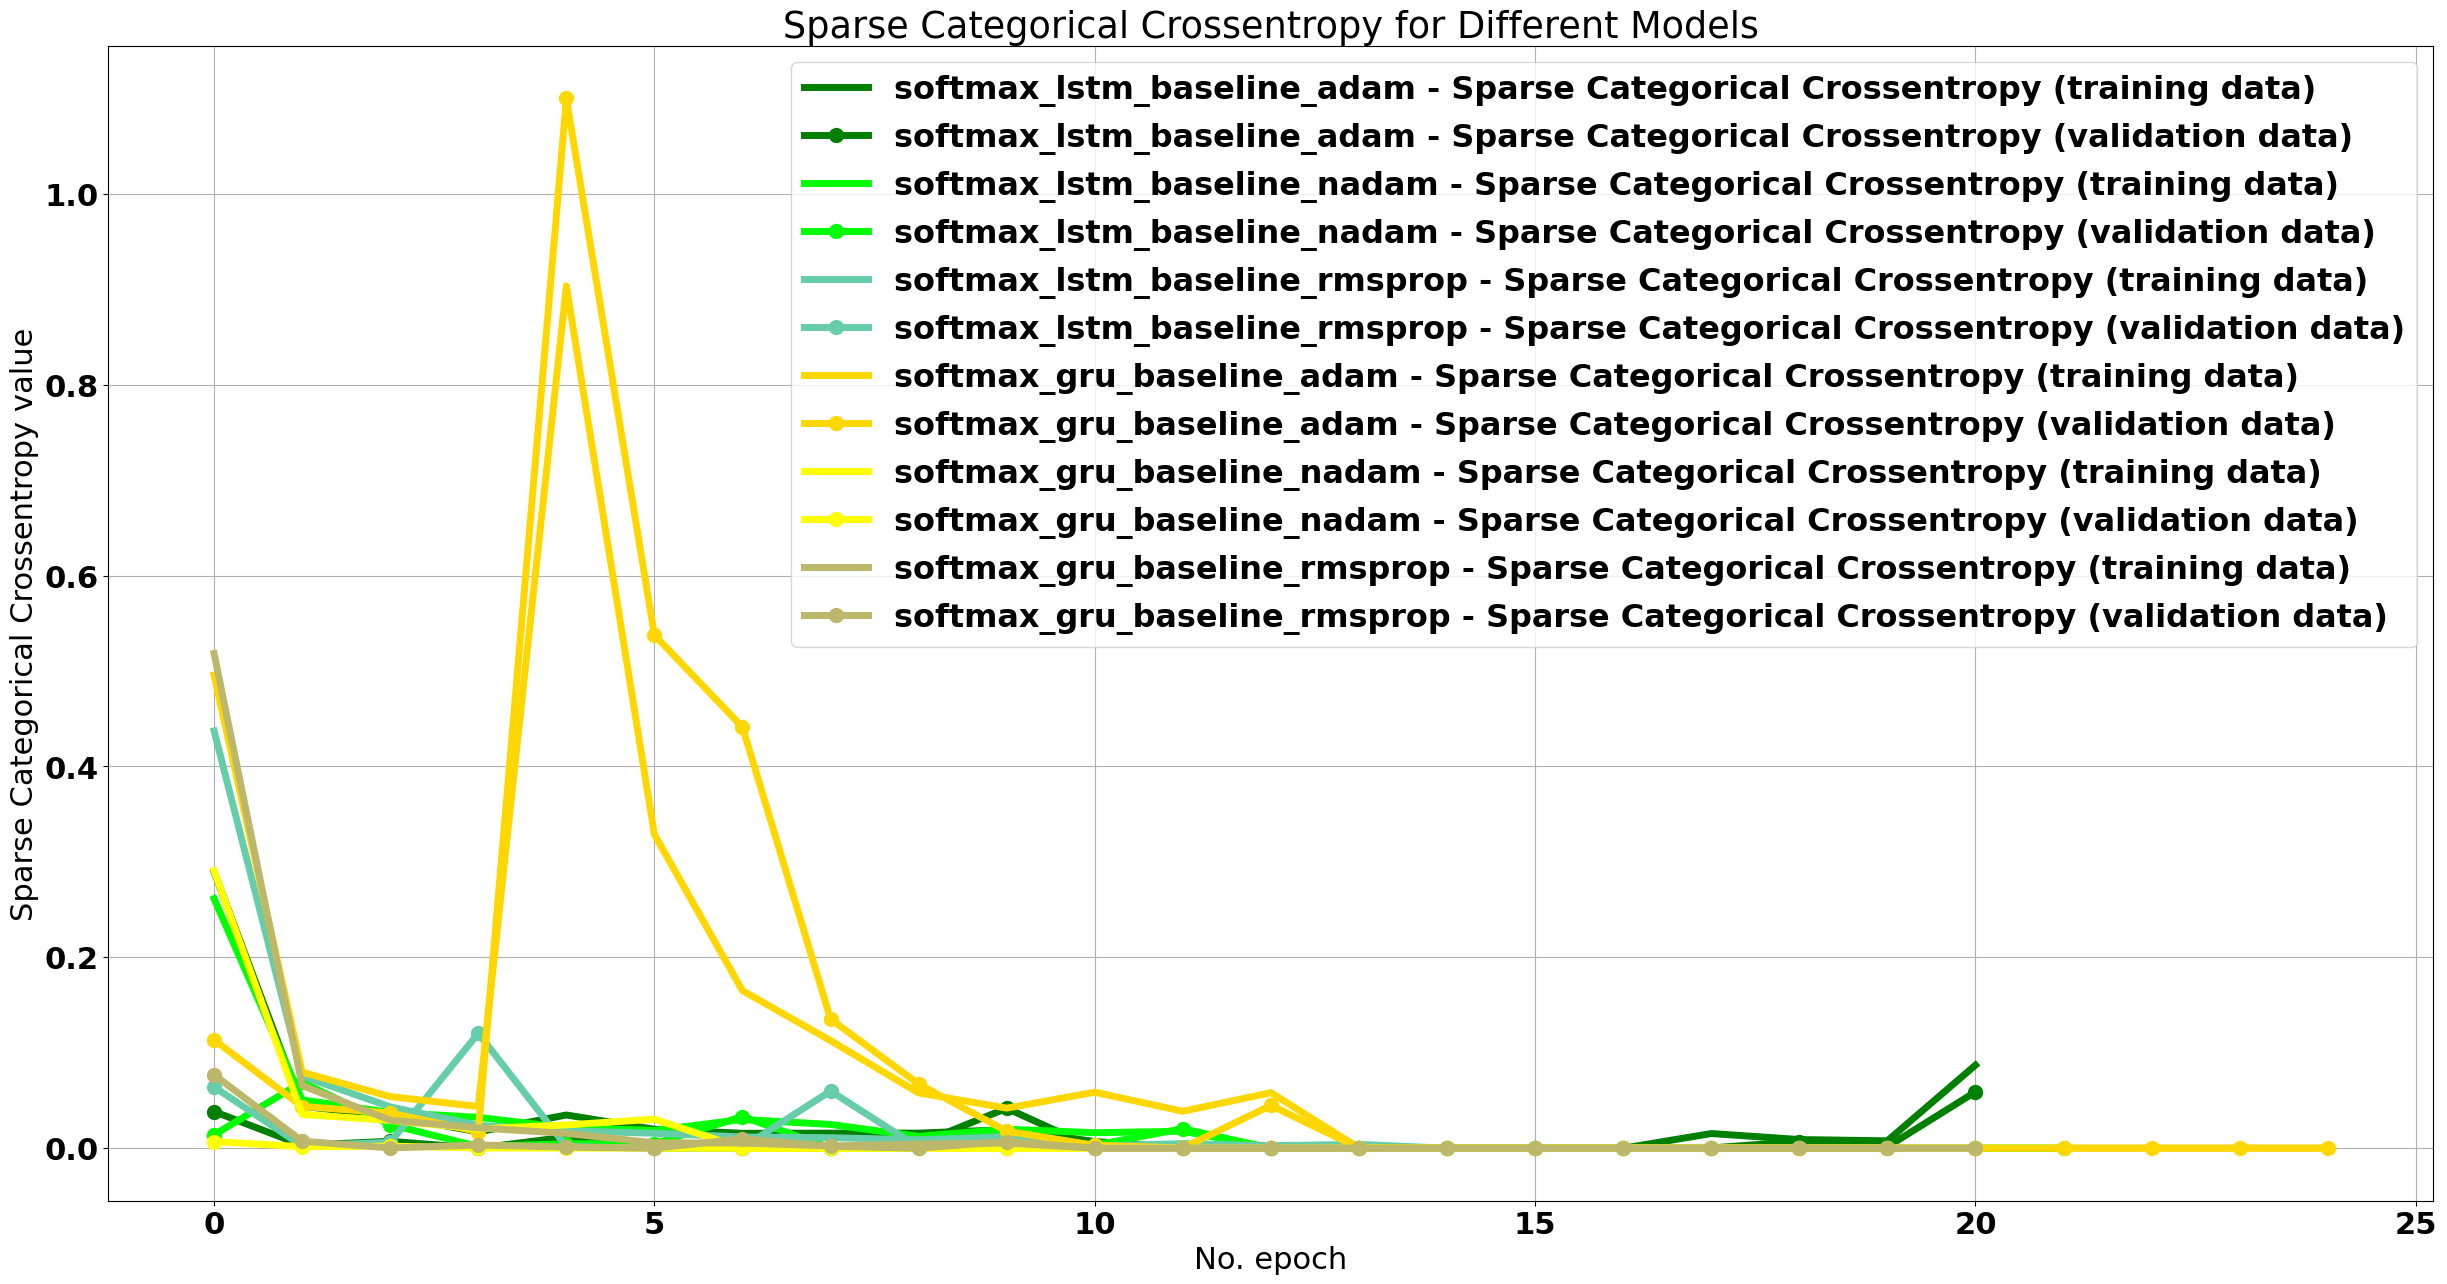

In [31]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

for model_name in baseline_models:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot, linewidth=5)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20, linewidth=5)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right", frameon=True, fontsize=23)
plt.savefig(os.path.join("figures", "baseline_models_comparission_entropy.png"), bbox_inches='tight')
plt.grid(True)
plt.show()

In [36]:
models_to_test.keys()

dict_keys(['softmax_lstm_adam', 'softmax_lstm_nadam', 'softmax_lstm_rmsprop', 'softmax_gru_adam', 'softmax_gru_nadam', 'softmax_gru_rmsprop', 'softmax_lstm_baseline_adam', 'softmax_lstm_baseline_nadam', 'softmax_lstm_baseline_rmsprop', 'softmax_gru_baseline_adam', 'softmax_gru_baseline_nadam', 'softmax_gru_baseline_rmsprop'])

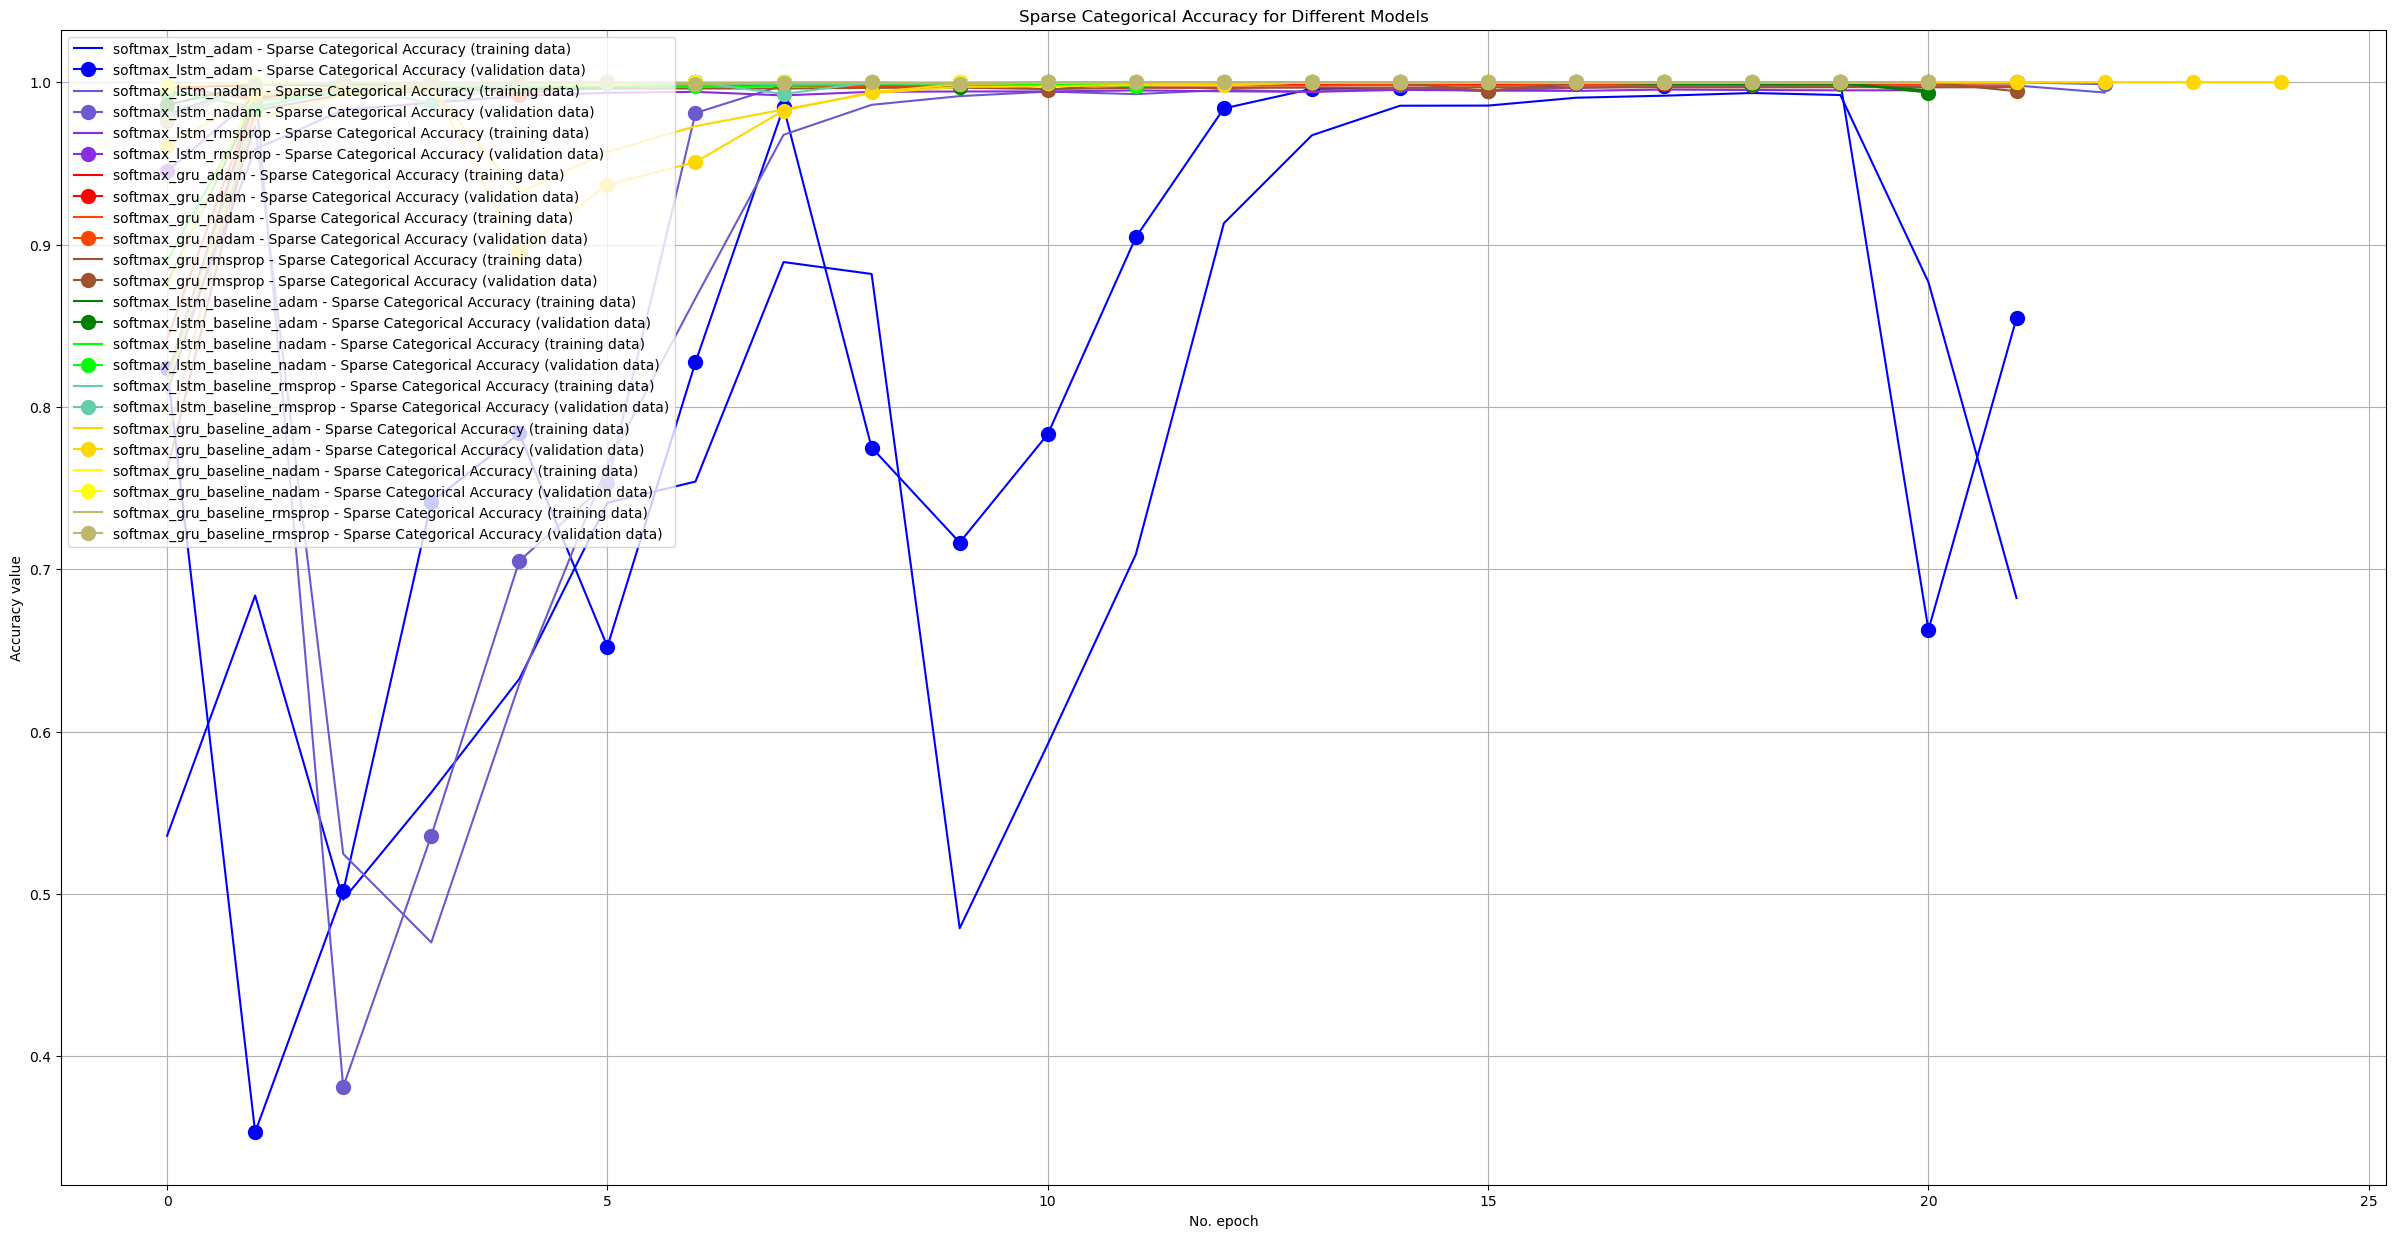

In [29]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

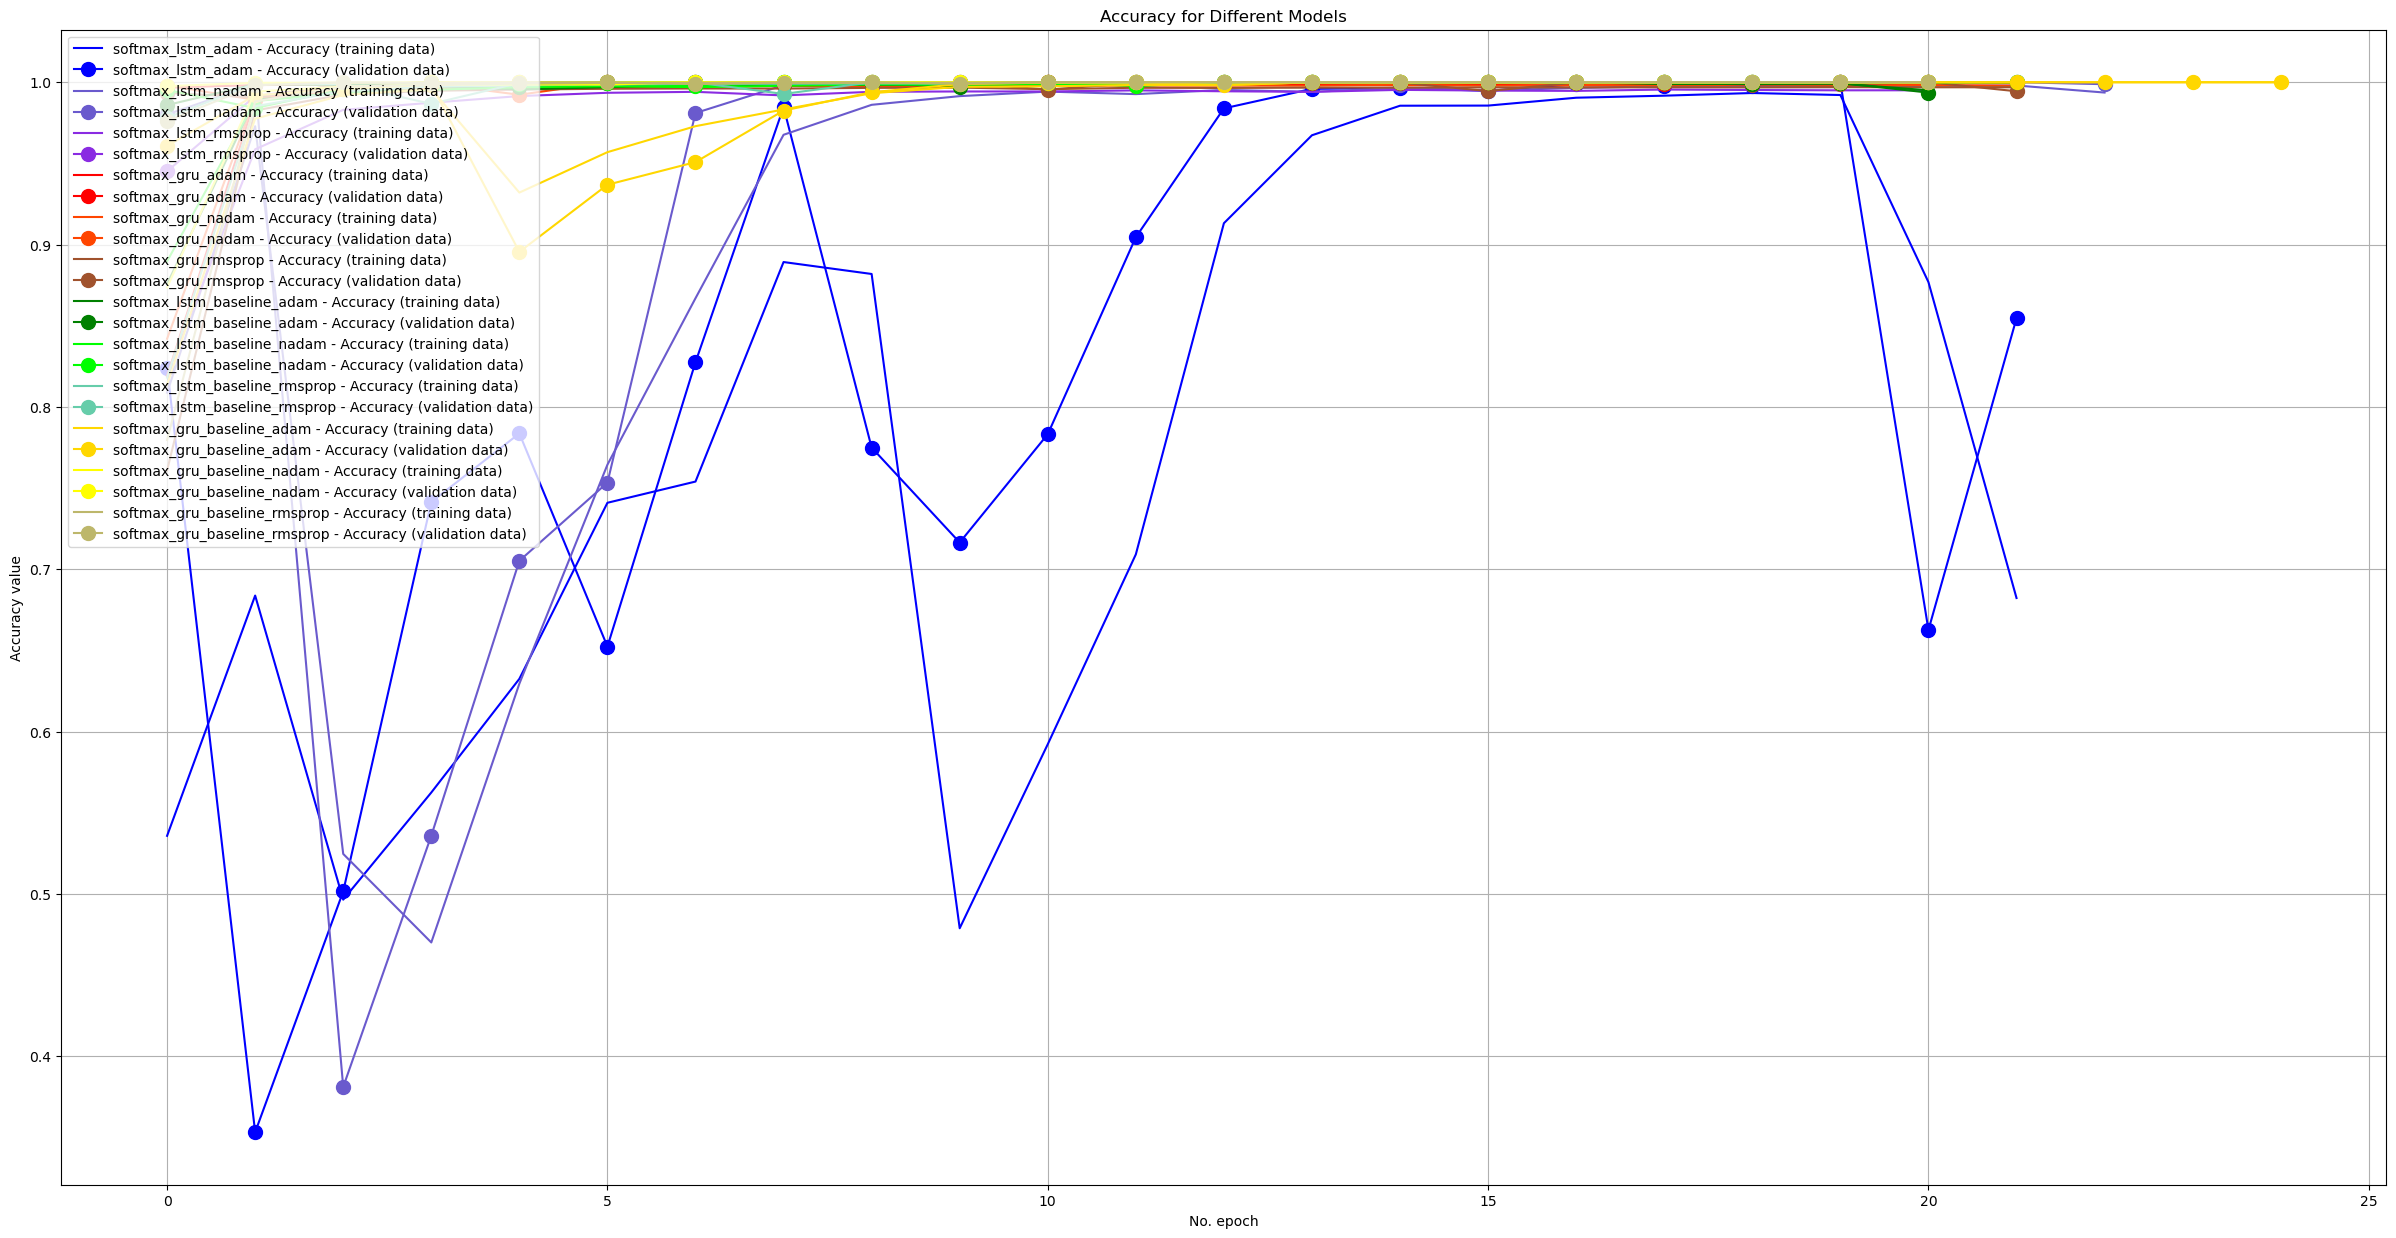

In [30]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['accuracy'], label=f'{model_name} - Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## Validating Model

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef, classification_report

labels = [ "Baseline", "Stress", "Amusement" ]

pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [32]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [34]:
validation_features = data["validation_data_features"]
validation_targets = data["validation_data_targets"]

In [35]:
for label_id in [0, 4, 5]:
    validation_features, validation_targets = remove_data(validation_features, validation_targets, label_id)
print(validation_features.shape, validation_targets.shape)

for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    validation_targets = update_labels(validation_targets, old_label_id, new_label_id)
print(validation_features.shape, validation_targets.shape)
print_distributions_of_labels(validation_targets)

(15256, 630, 5) (15256,)
(15256, 630, 5) (15256,)
[0 1 2] [8100 4677 2479]
[0 1 2] [0.53093865 0.30656791 0.16249345]


In [36]:
validation_features.shape, validation_targets.shape

((15256, 630, 5), (15256,))

############### START MODEL softmax_lstm_adam ###############


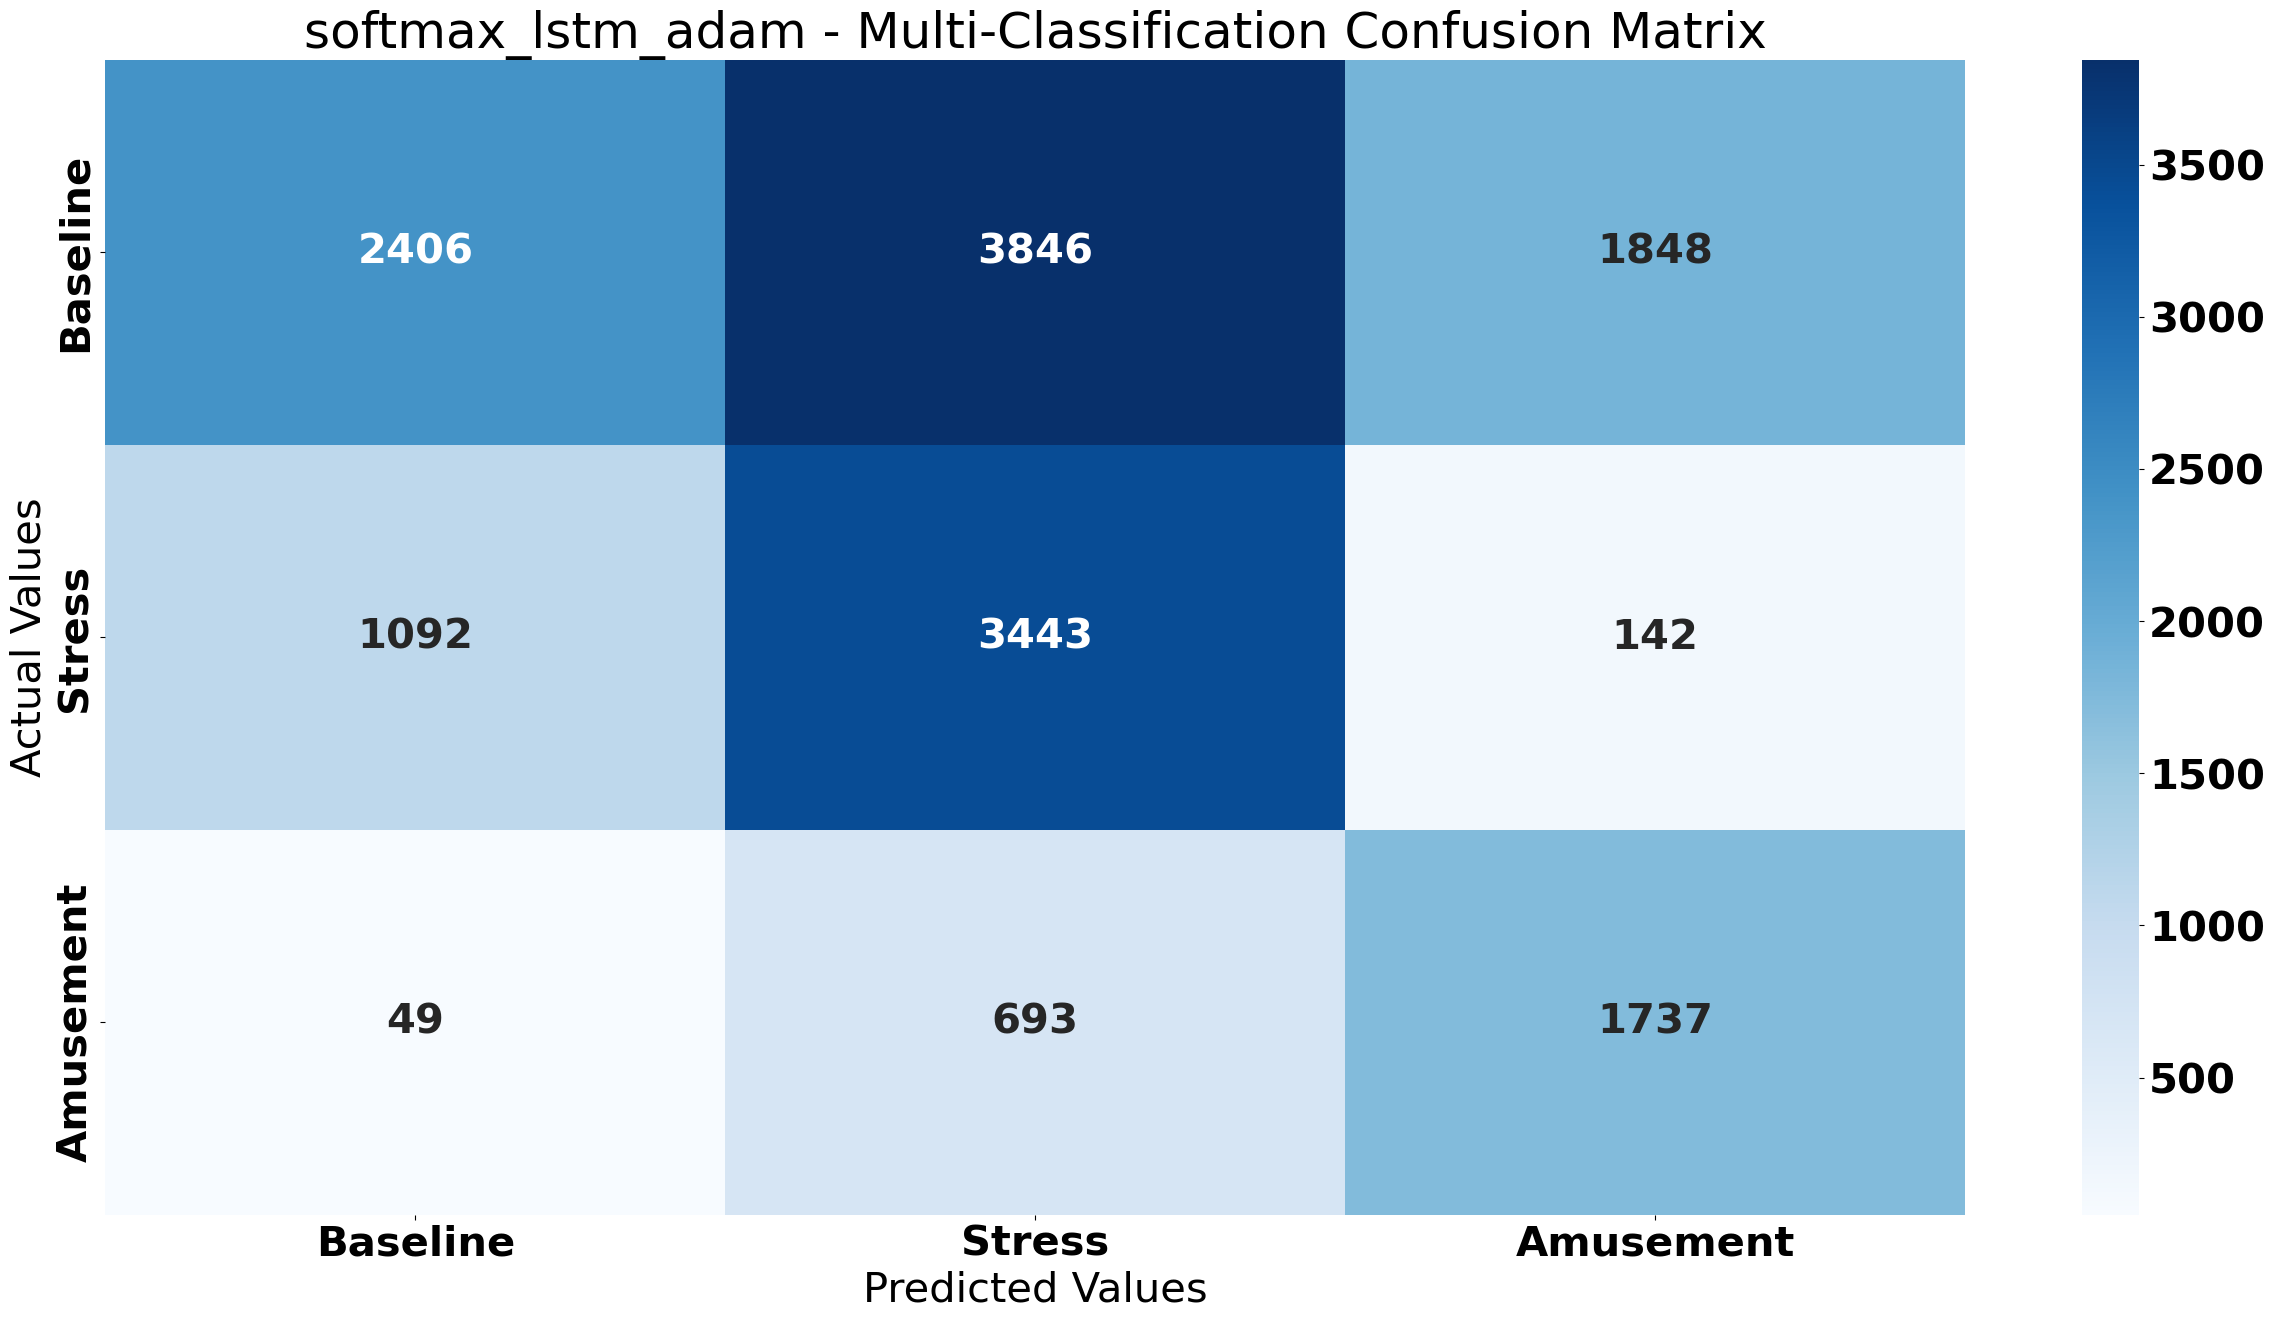

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.68      0.30      0.41      8100
      Stress       0.43      0.74      0.54      4677
   Amusement       0.47      0.70      0.56      2479

    accuracy                           0.50     15256
   macro avg       0.53      0.58      0.51     15256
weighted avg       0.57      0.50      0.48     15256

Matthews Correlation: 0.287089538169155
############### END MODEL softmax_lstm_adam ###############
############### START MODEL softmax_lstm_nadam ###############


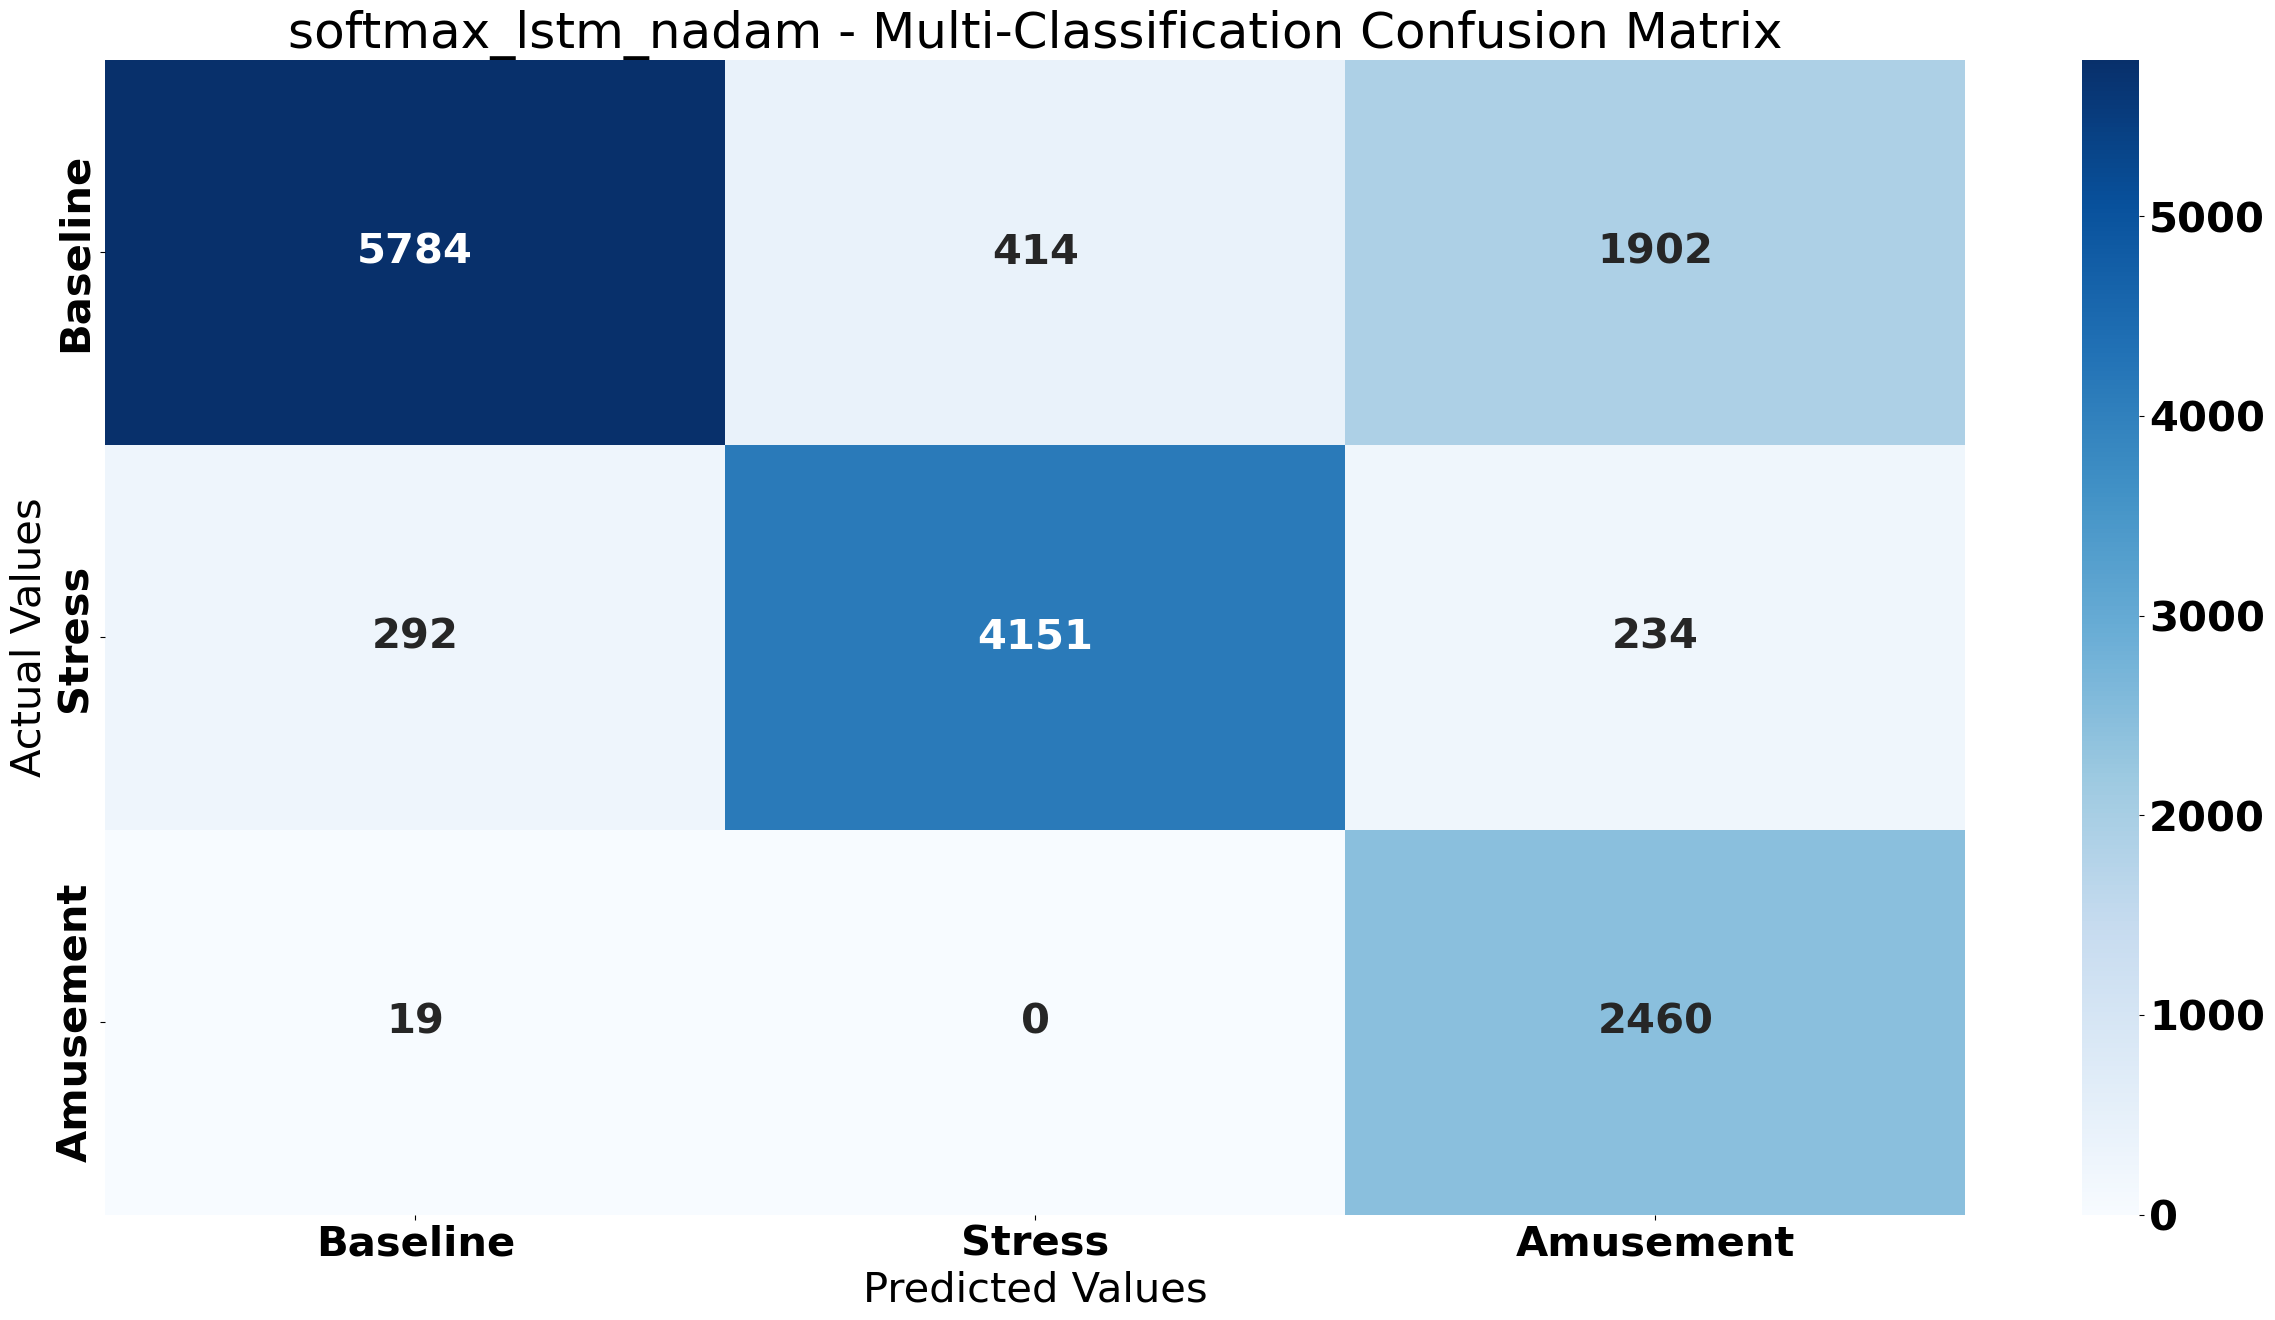

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.95      0.71      0.81      8100
      Stress       0.91      0.89      0.90      4677
   Amusement       0.54      0.99      0.70      2479

    accuracy                           0.81     15256
   macro avg       0.80      0.86      0.80     15256
weighted avg       0.87      0.81      0.82     15256

Matthews Correlation: 0.731795019612323
############### END MODEL softmax_lstm_nadam ###############
############### START MODEL softmax_lstm_rmsprop ###############


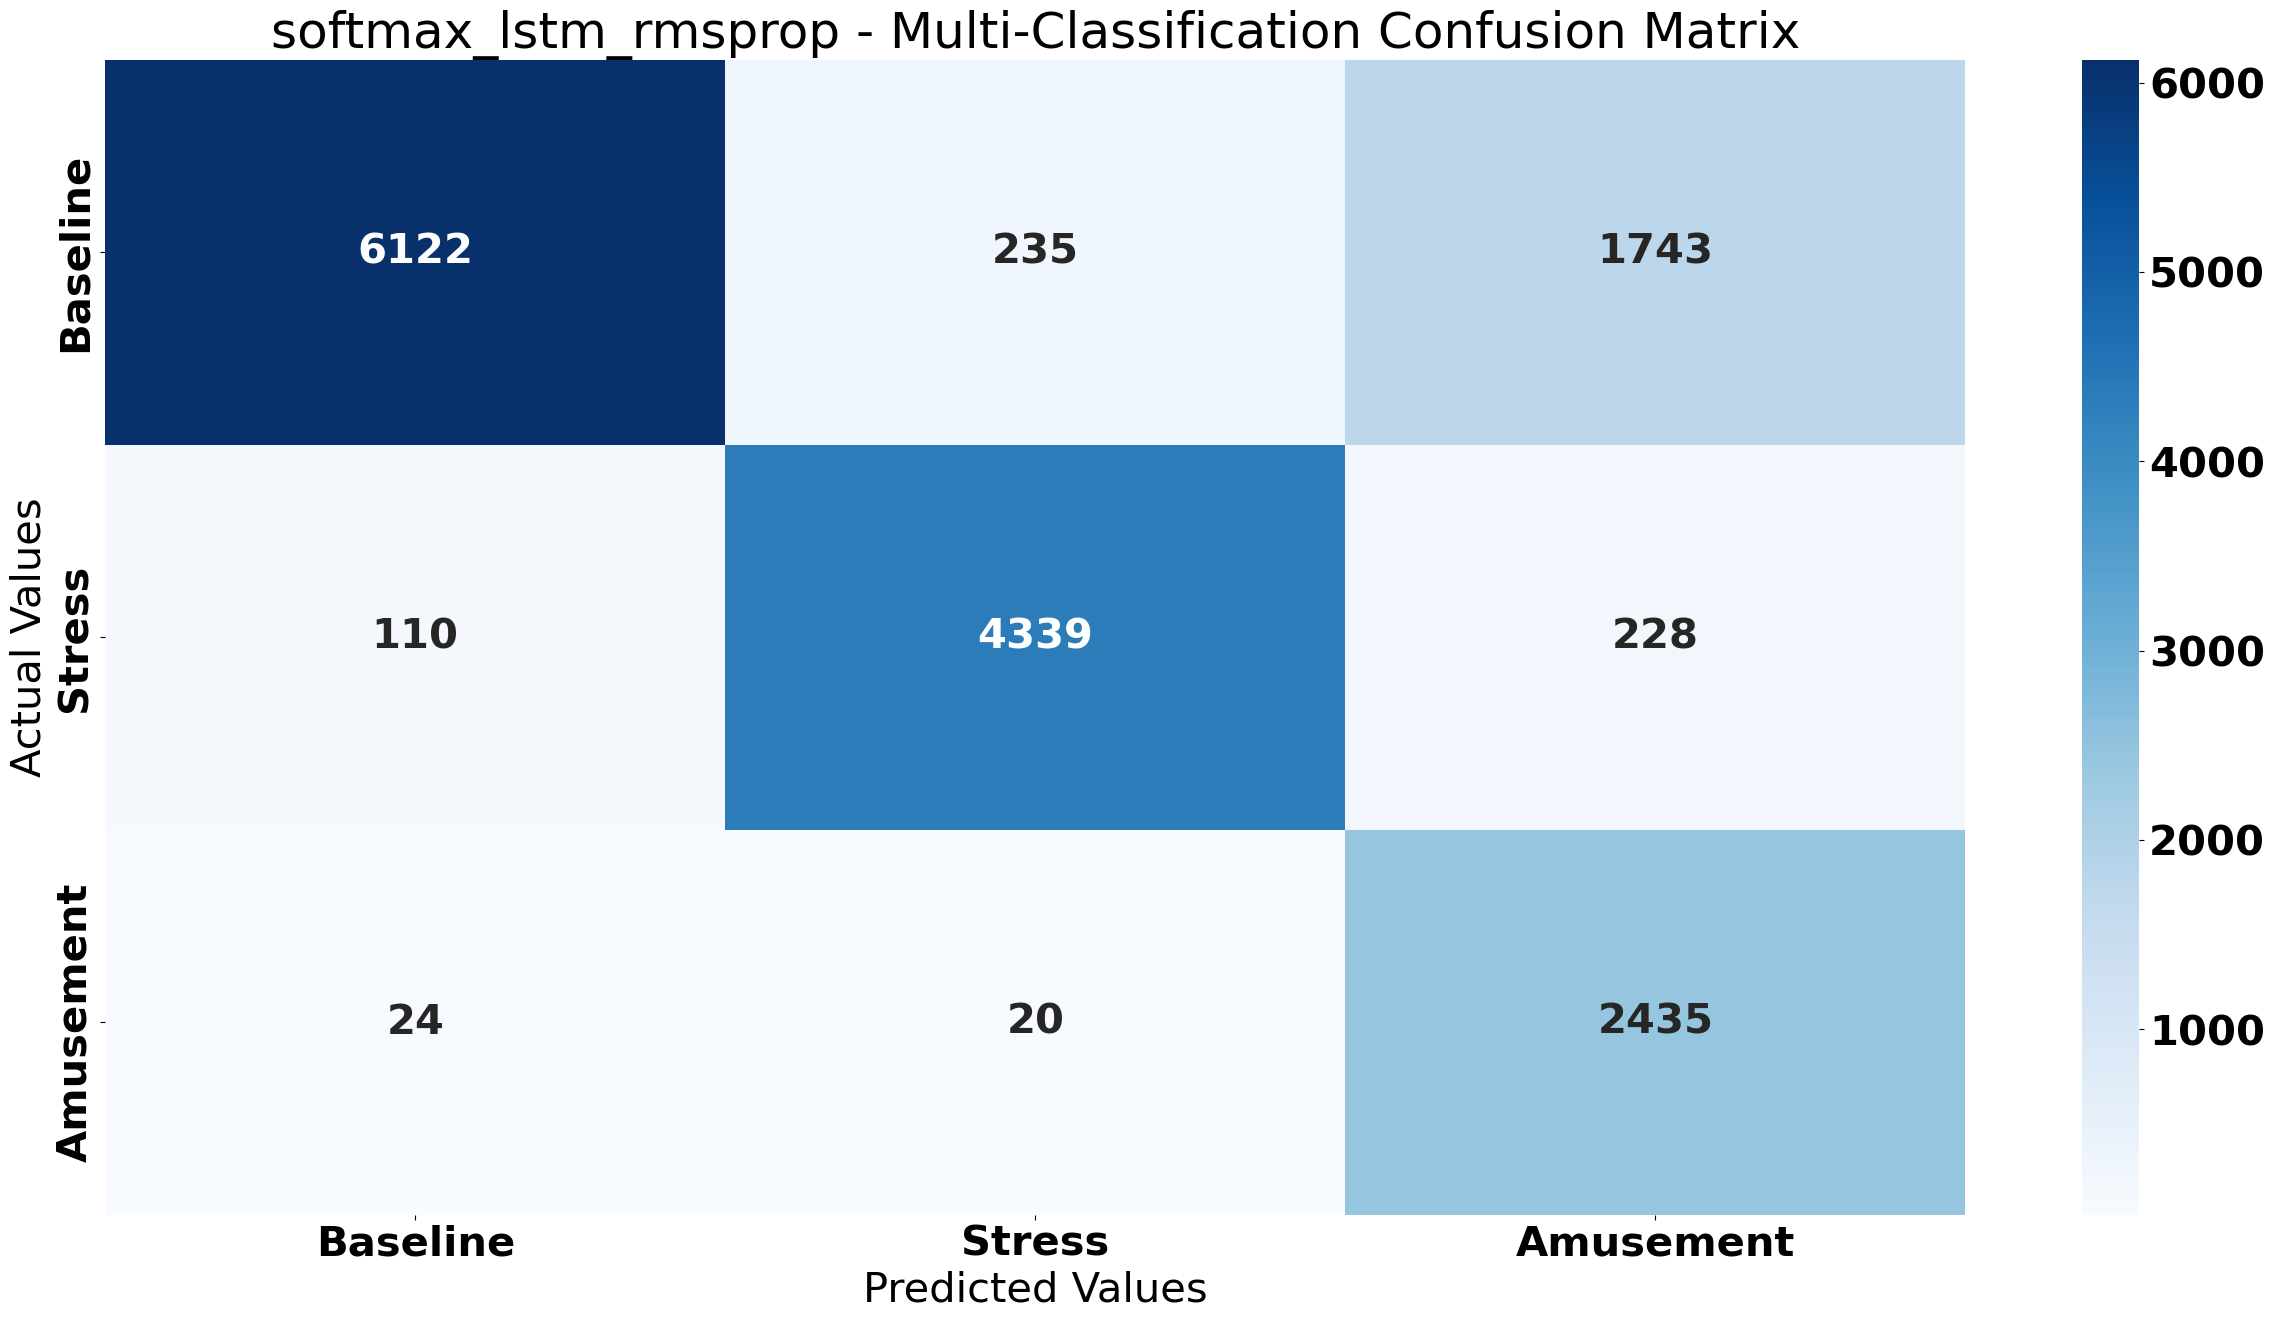

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.98      0.76      0.85      8100
      Stress       0.94      0.93      0.94      4677
   Amusement       0.55      0.98      0.71      2479

    accuracy                           0.85     15256
   macro avg       0.83      0.89      0.83     15256
weighted avg       0.90      0.85      0.85     15256

Matthews Correlation: 0.778829521134811
############### END MODEL softmax_lstm_rmsprop ###############
############### START MODEL softmax_gru_adam ###############


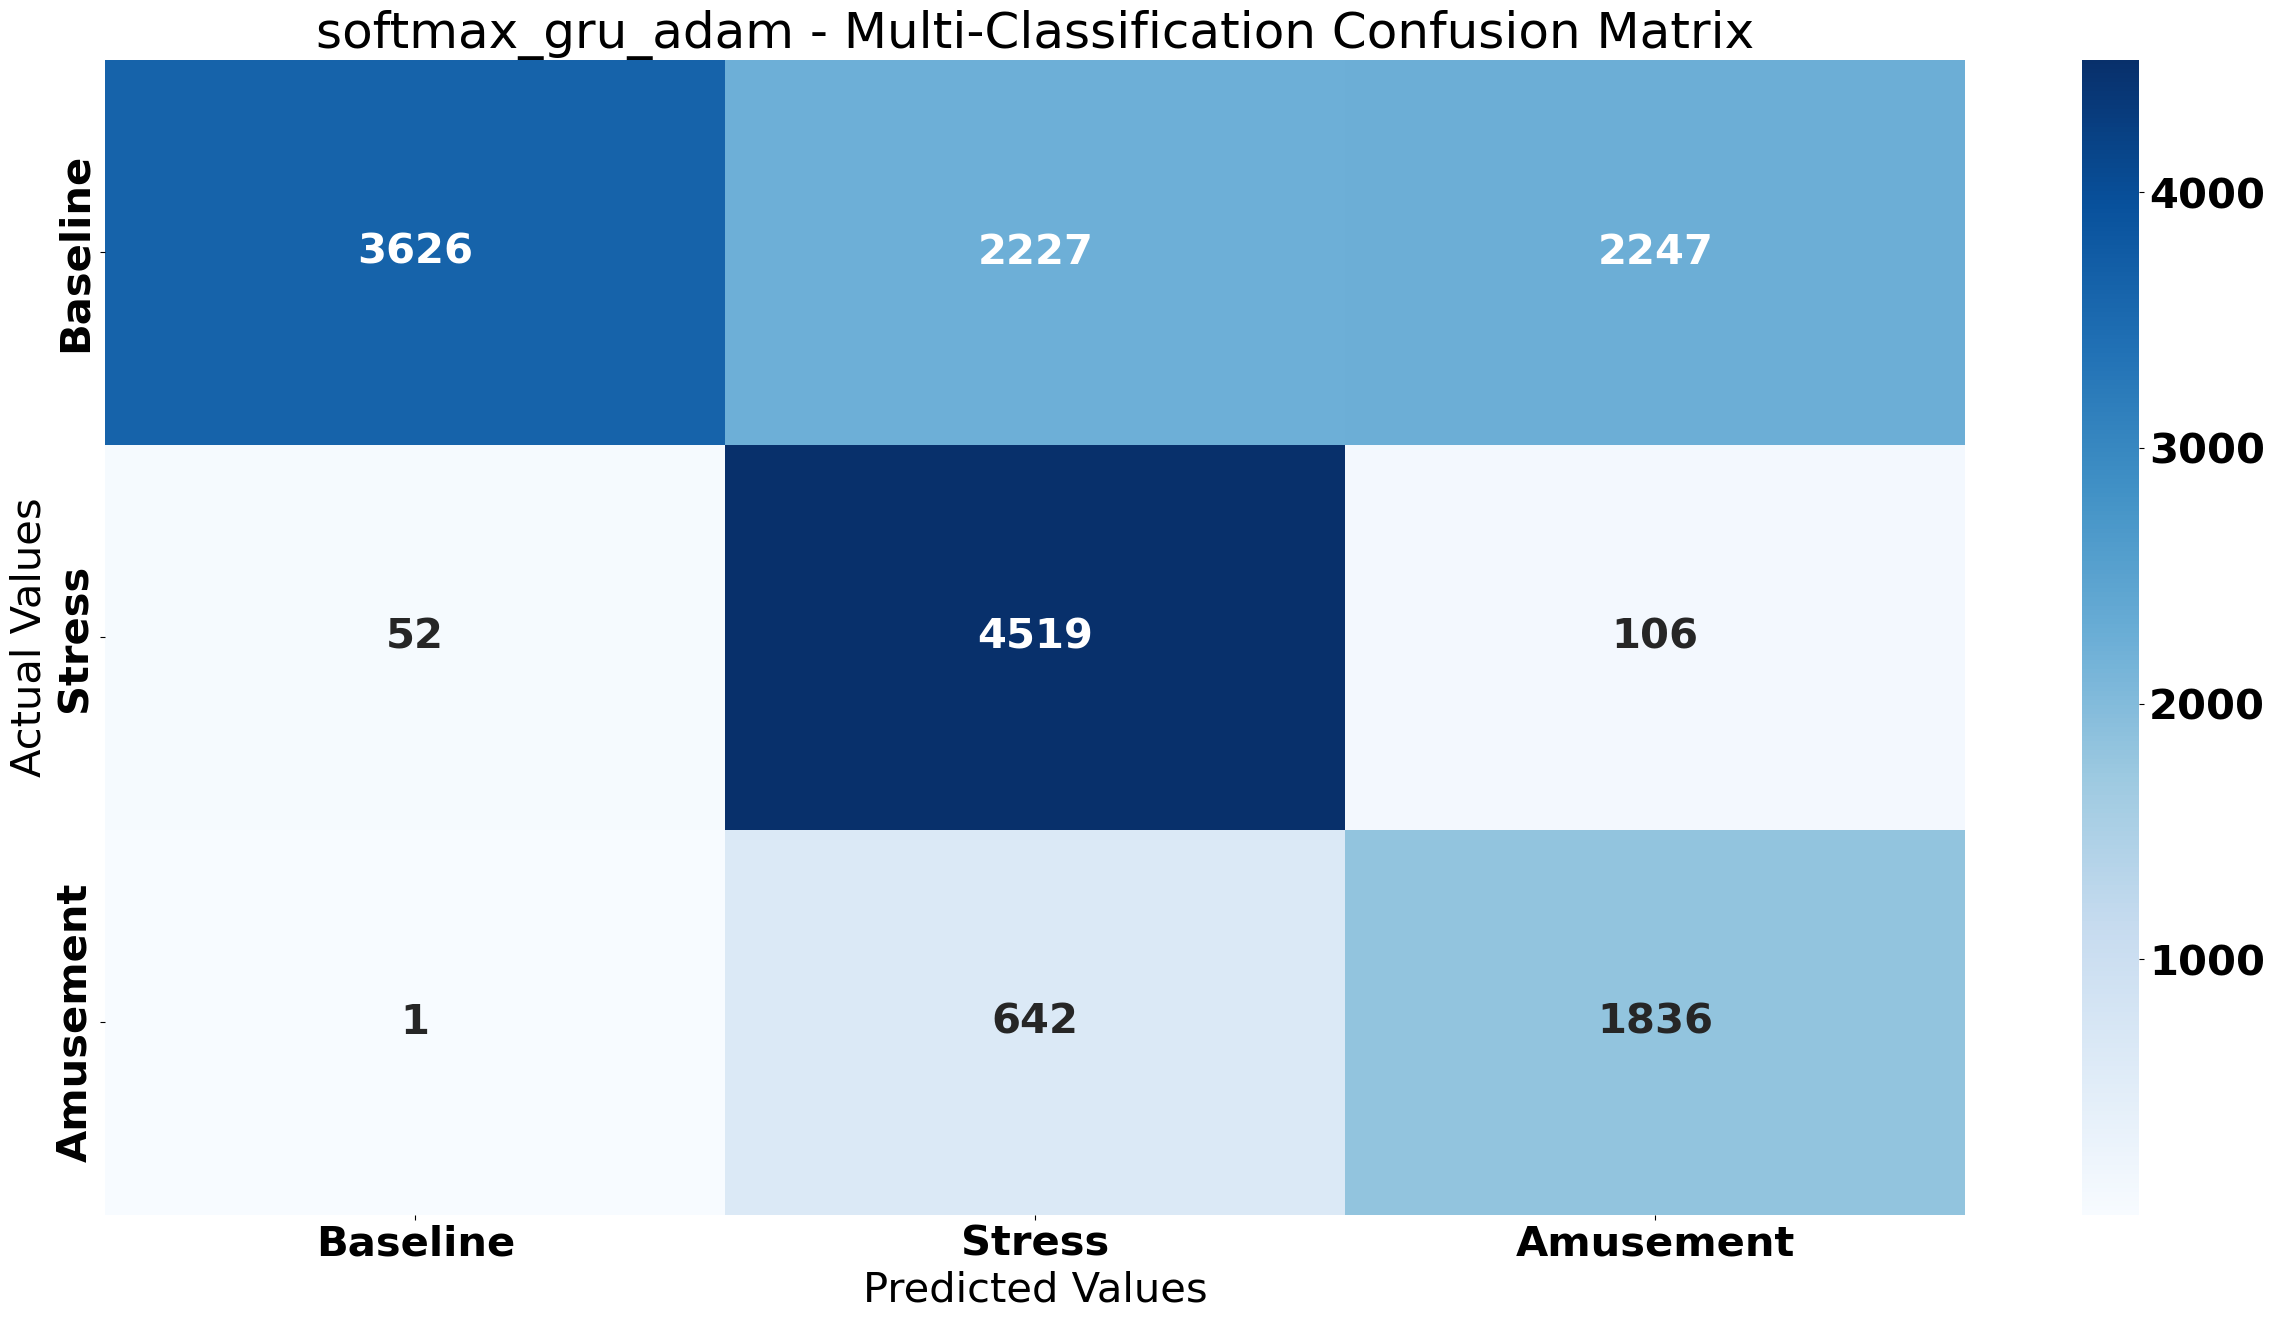

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.99      0.45      0.62      8100
      Stress       0.61      0.97      0.75      4677
   Amusement       0.44      0.74      0.55      2479

    accuracy                           0.65     15256
   macro avg       0.68      0.72      0.64     15256
weighted avg       0.78      0.65      0.65     15256

Matthews Correlation: 0.5420206387391586
############### END MODEL softmax_gru_adam ###############
############### START MODEL softmax_gru_nadam ###############


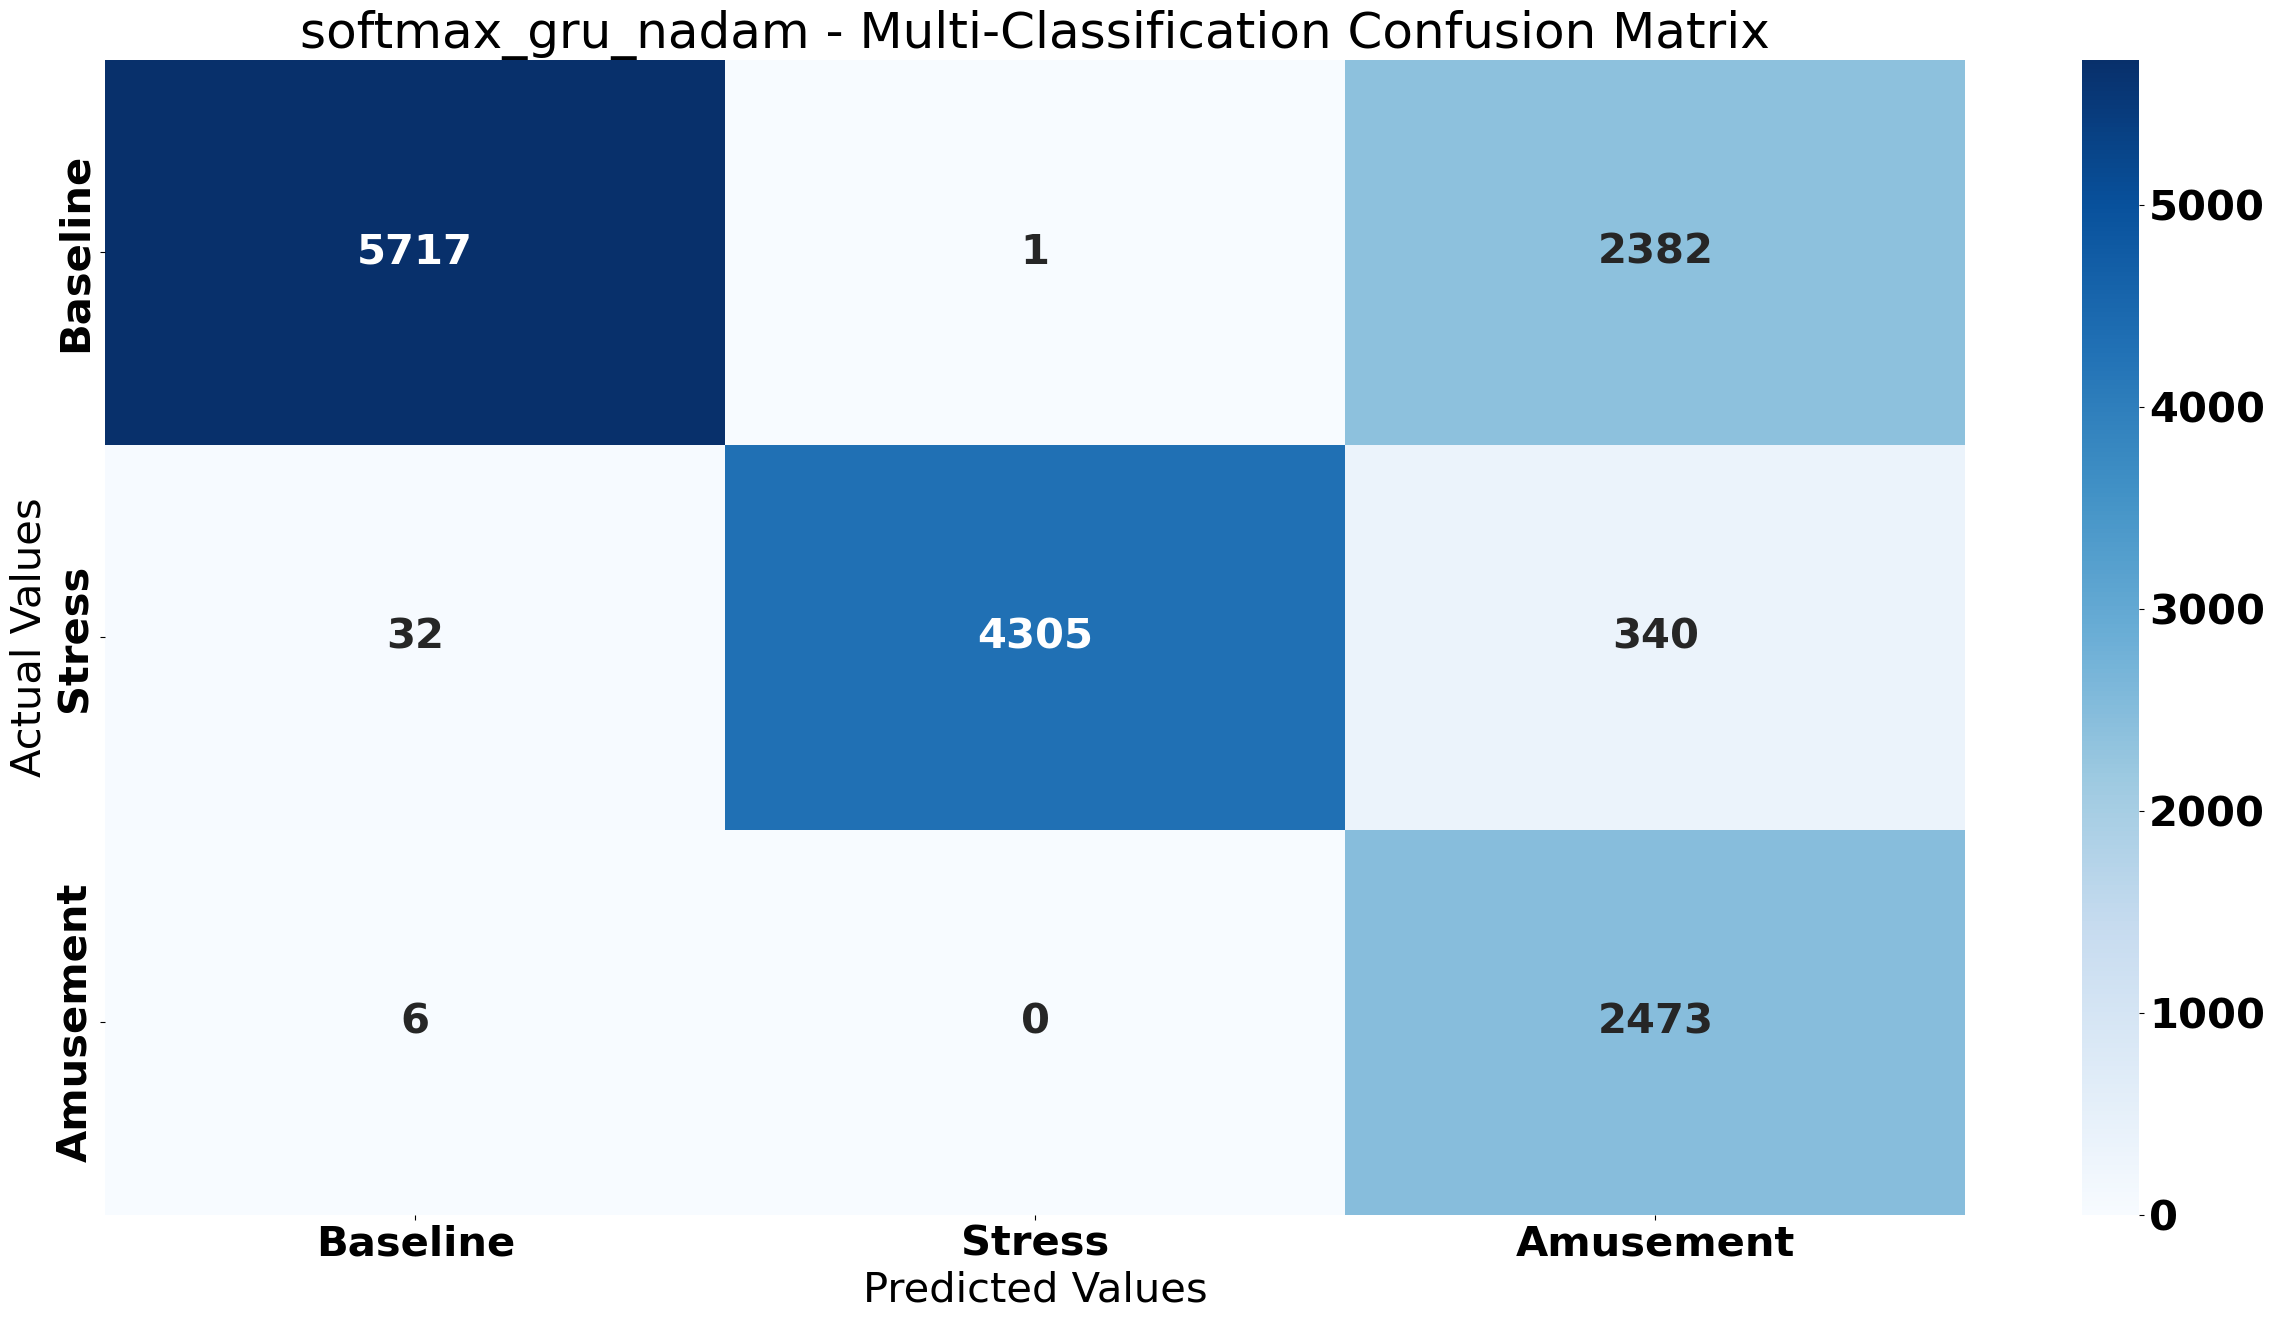

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.99      0.71      0.83      8100
      Stress       1.00      0.92      0.96      4677
   Amusement       0.48      1.00      0.64      2479

    accuracy                           0.82     15256
   macro avg       0.82      0.87      0.81     15256
weighted avg       0.91      0.82      0.84     15256

Matthews Correlation: 0.758058565711649
############### END MODEL softmax_gru_nadam ###############
############### START MODEL softmax_gru_rmsprop ###############


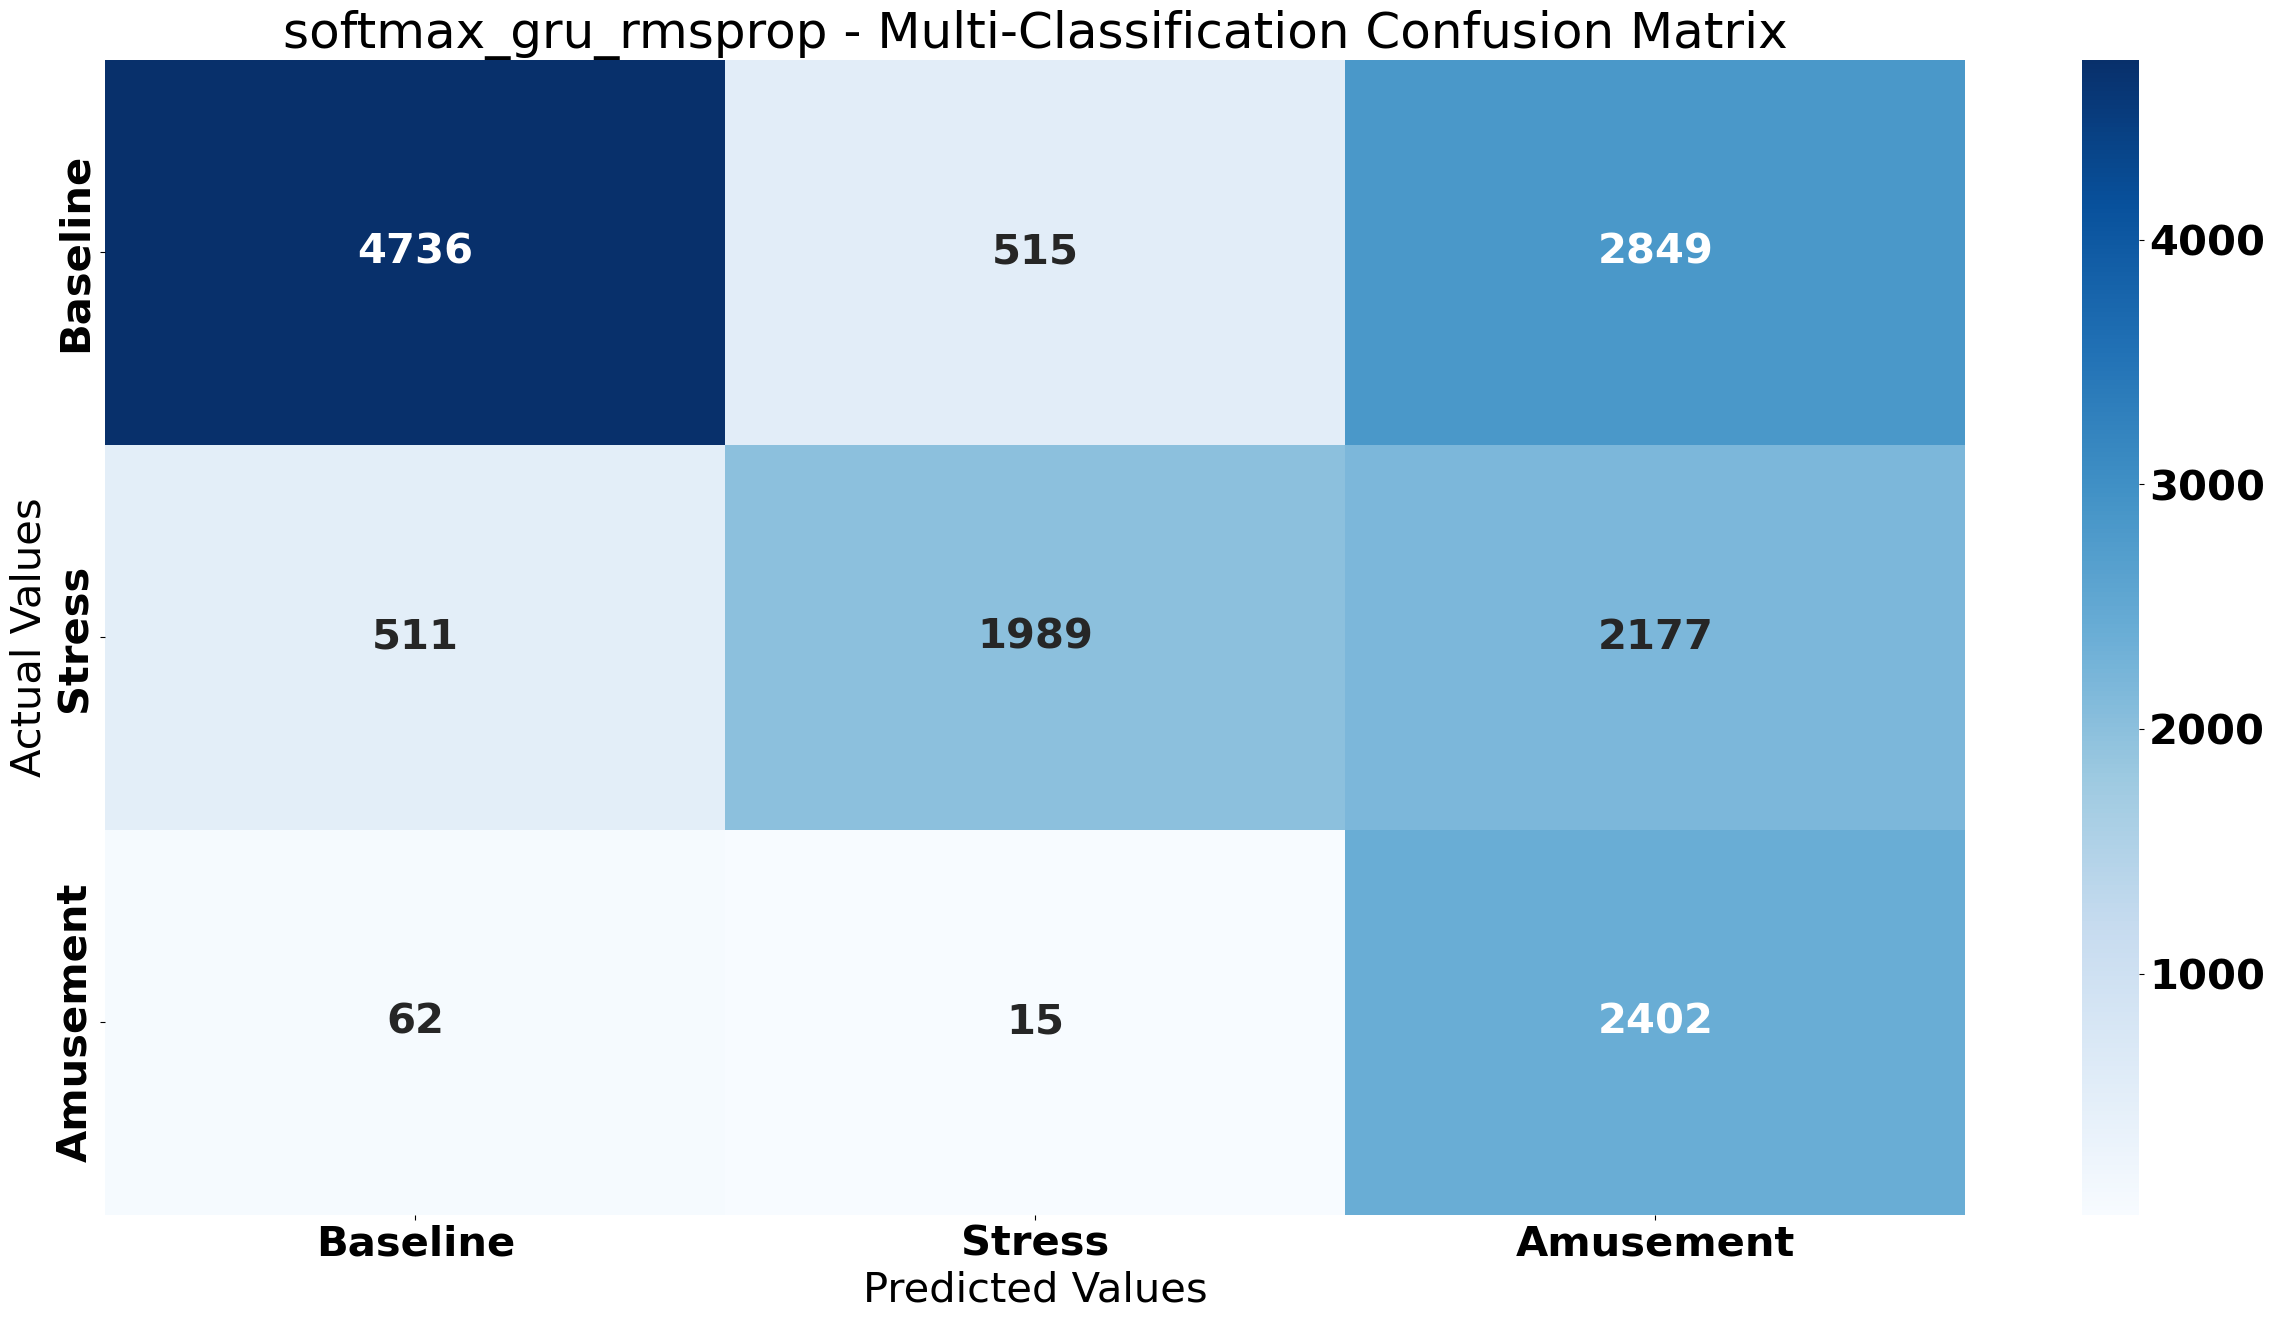

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.89      0.58      0.71      8100
      Stress       0.79      0.43      0.55      4677
   Amusement       0.32      0.97      0.48      2479

    accuracy                           0.60     15256
   macro avg       0.67      0.66      0.58     15256
weighted avg       0.77      0.60      0.62     15256

Matthews Correlation: 0.46817925775242086
############### END MODEL softmax_gru_rmsprop ###############
############### START MODEL softmax_lstm_baseline_adam ###############


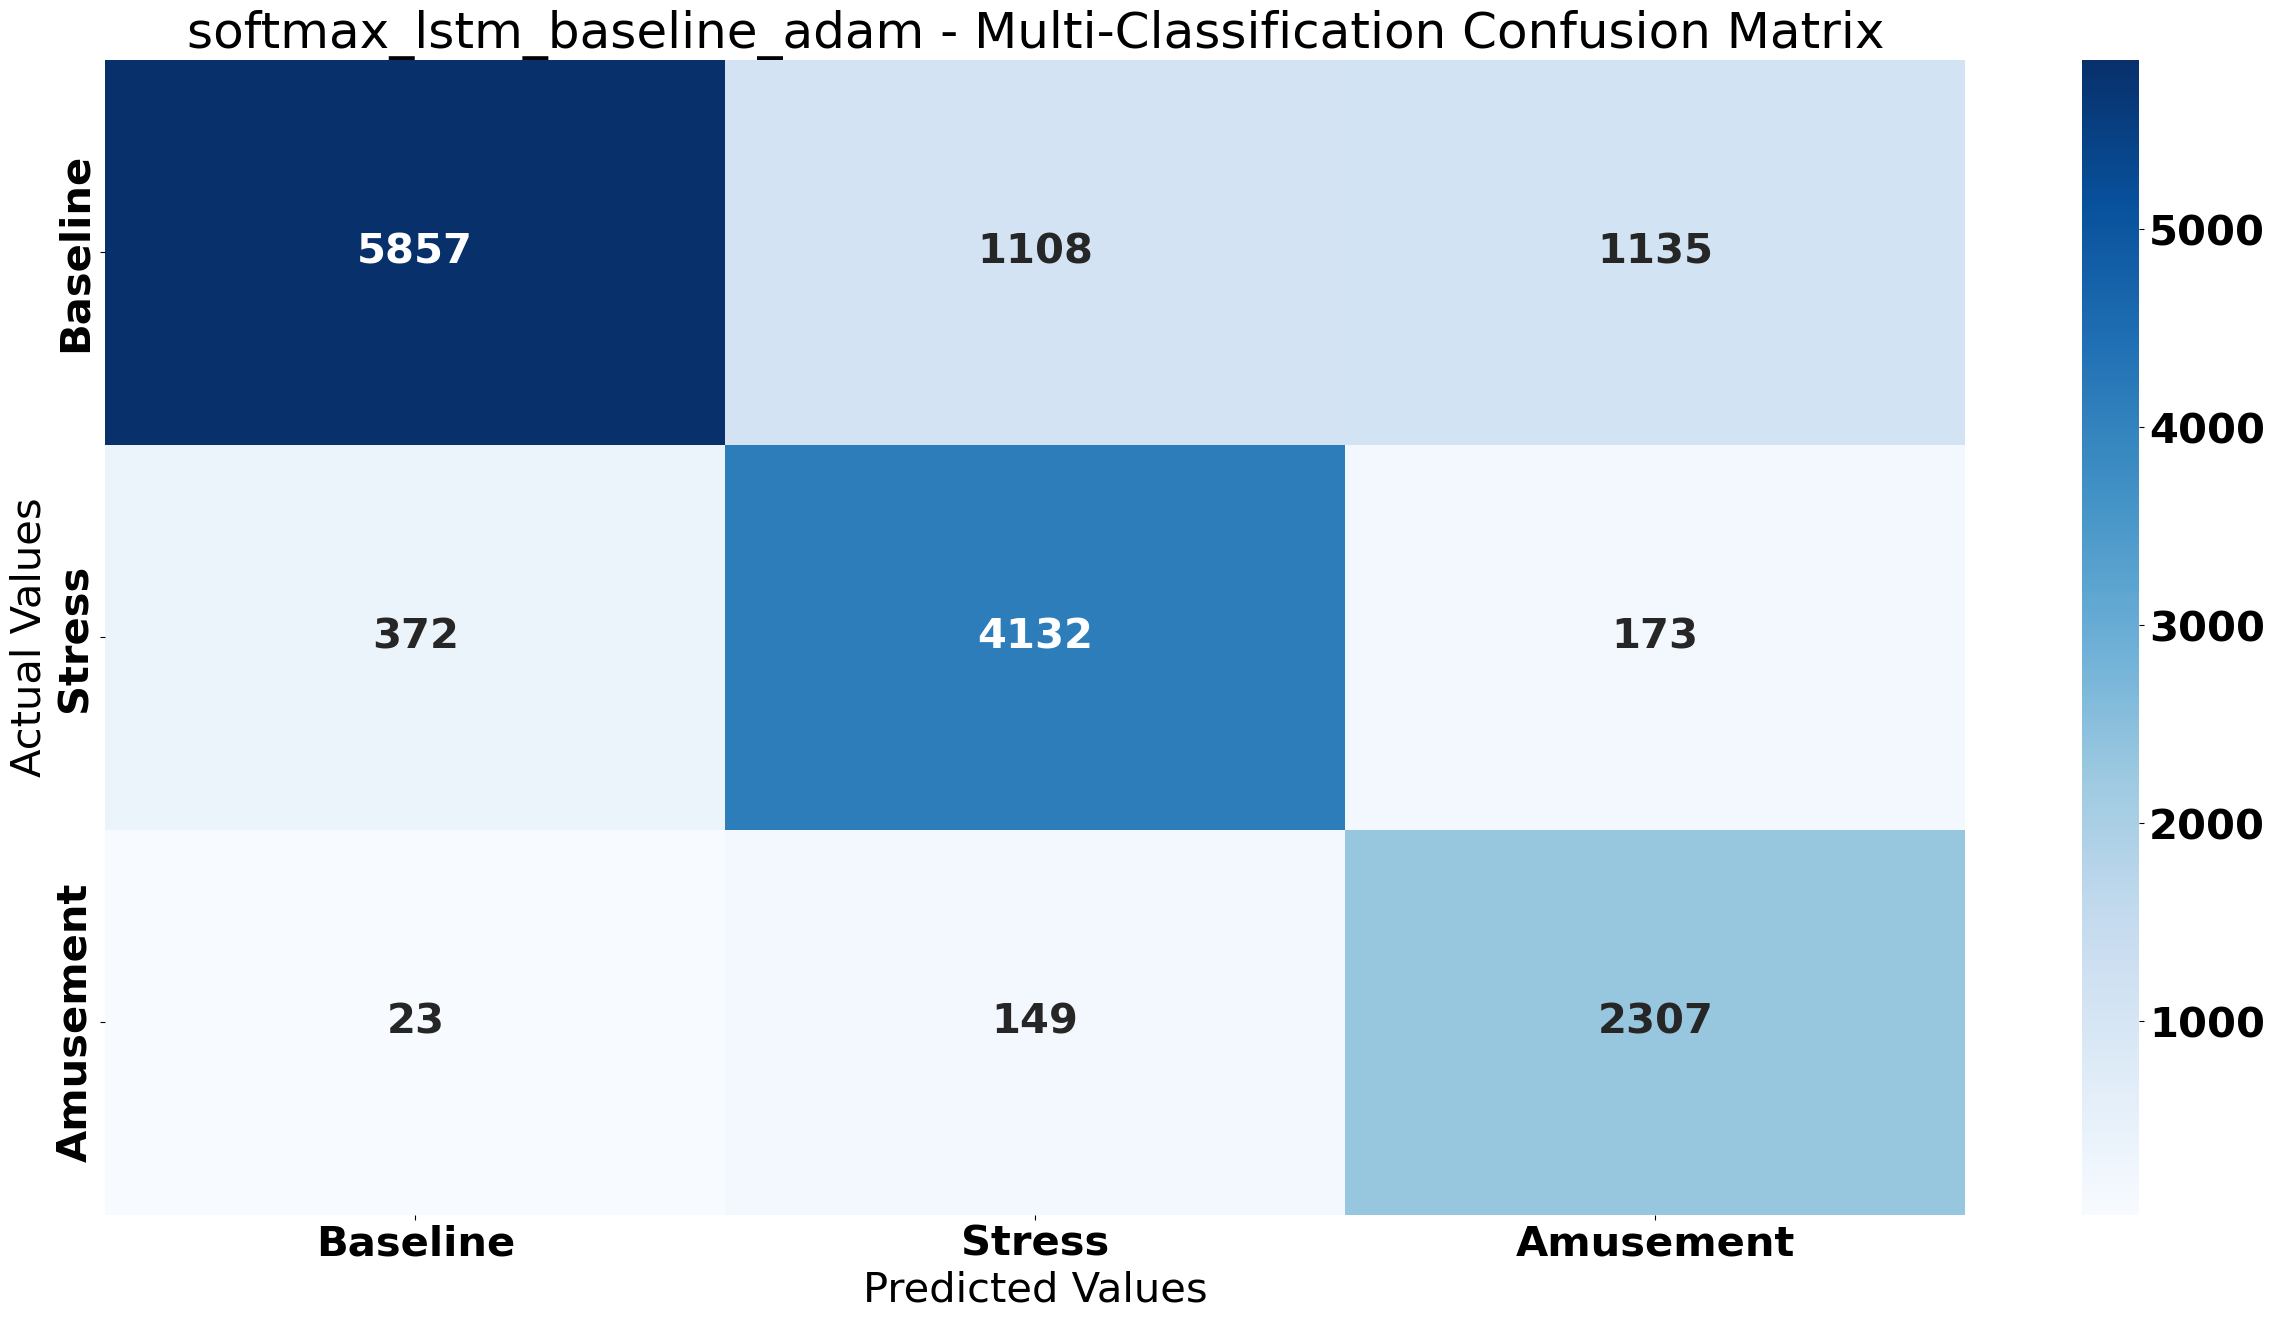

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.94      0.72      0.82      8100
      Stress       0.77      0.88      0.82      4677
   Amusement       0.64      0.93      0.76      2479

    accuracy                           0.81     15256
   macro avg       0.78      0.85      0.80     15256
weighted avg       0.84      0.81      0.81     15256

Matthews Correlation: 0.7078599359699955
############### END MODEL softmax_lstm_baseline_adam ###############
############### START MODEL softmax_lstm_baseline_nadam ###############


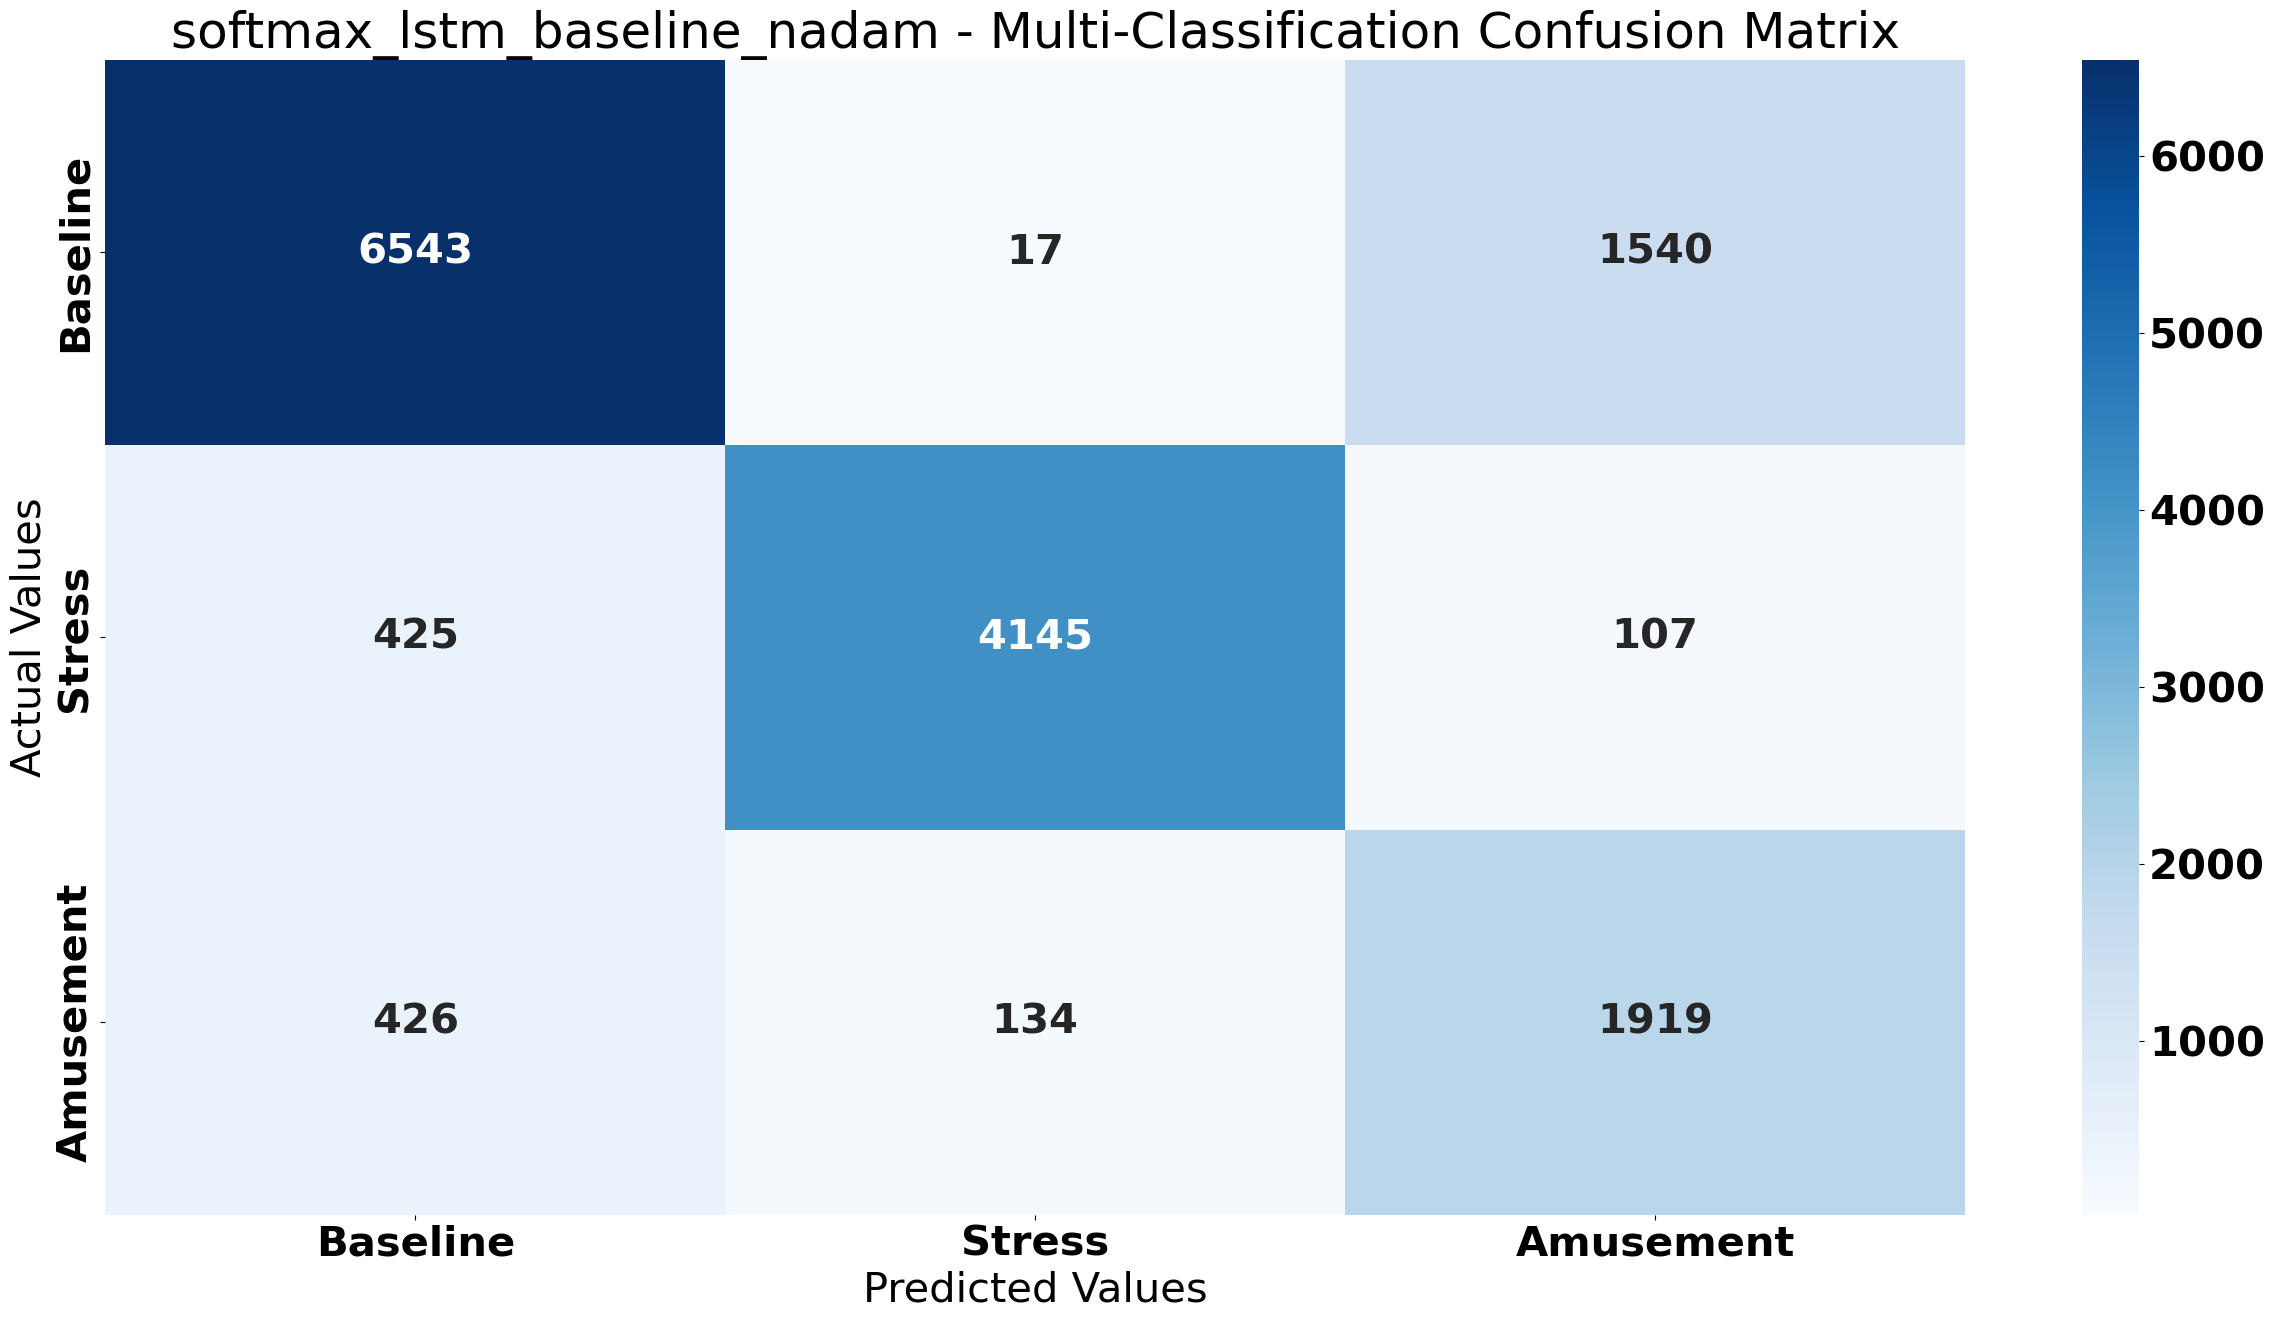

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.88      0.81      0.84      8100
      Stress       0.96      0.89      0.92      4677
   Amusement       0.54      0.77      0.63      2479

    accuracy                           0.83     15256
   macro avg       0.80      0.82      0.80     15256
weighted avg       0.85      0.83      0.83     15256

Matthews Correlation: 0.7240581419102875
############### END MODEL softmax_lstm_baseline_nadam ###############
############### START MODEL softmax_lstm_baseline_rmsprop ###############


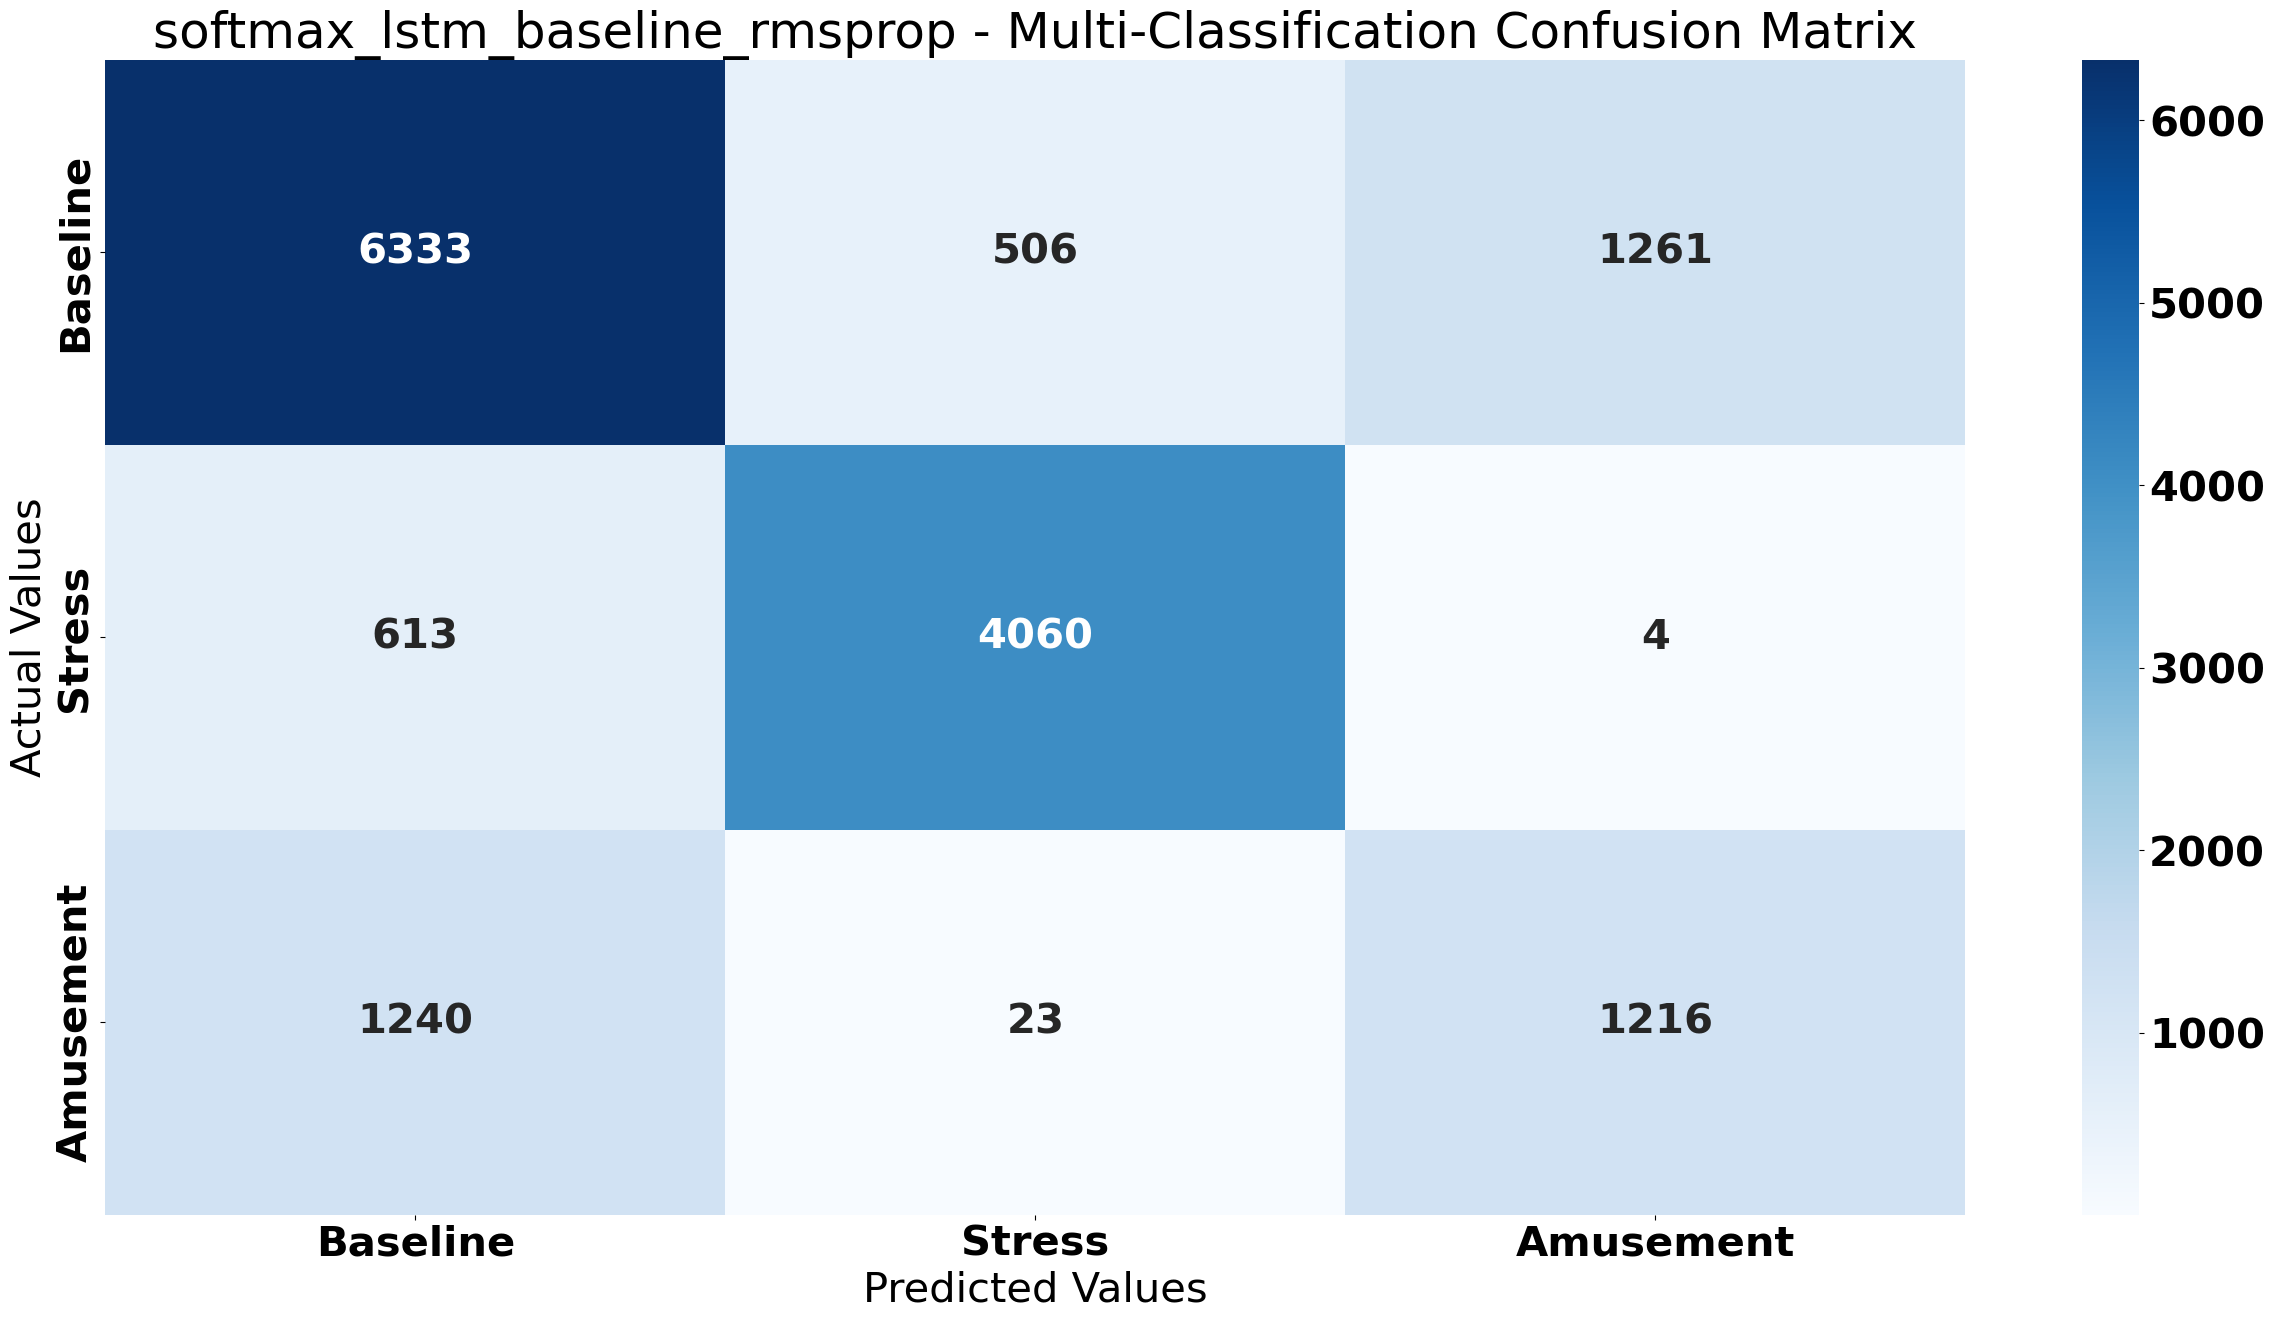

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.77      0.78      0.78      8100
      Stress       0.88      0.87      0.88      4677
   Amusement       0.49      0.49      0.49      2479

    accuracy                           0.76     15256
   macro avg       0.72      0.71      0.71     15256
weighted avg       0.76      0.76      0.76     15256

Matthews Correlation: 0.5992538147843008
############### END MODEL softmax_lstm_baseline_rmsprop ###############
############### START MODEL softmax_gru_baseline_adam ###############


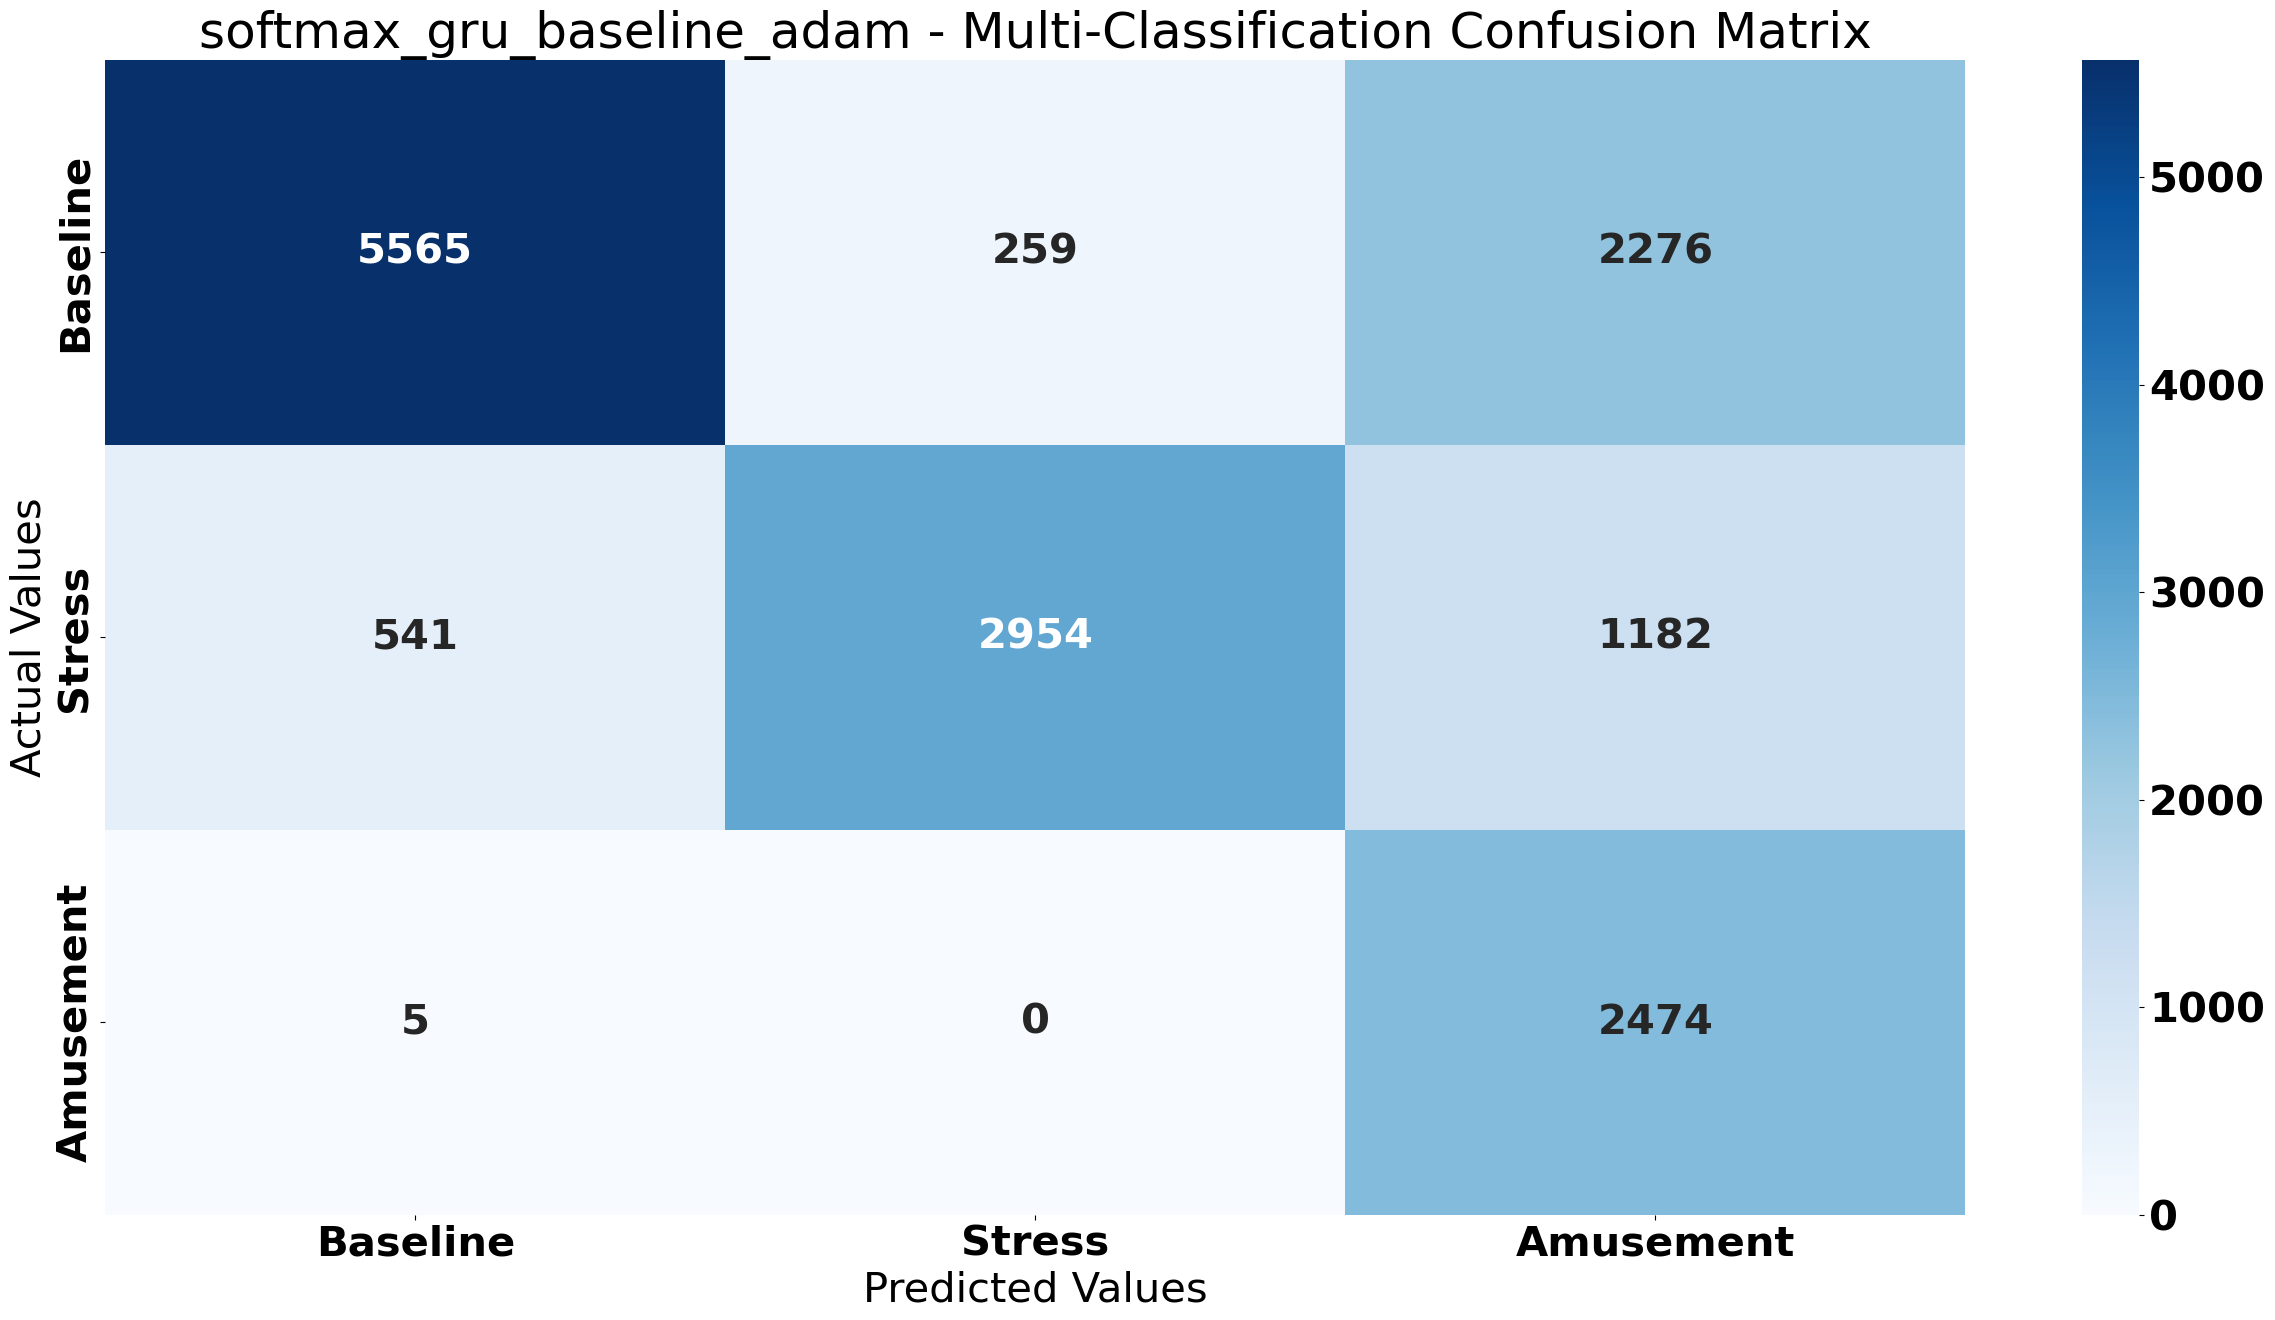

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.91      0.69      0.78      8100
      Stress       0.92      0.63      0.75      4677
   Amusement       0.42      1.00      0.59      2479

    accuracy                           0.72     15256
   macro avg       0.75      0.77      0.71     15256
weighted avg       0.83      0.72      0.74     15256

Matthews Correlation: 0.6127161975288196
############### END MODEL softmax_gru_baseline_adam ###############
############### START MODEL softmax_gru_baseline_nadam ###############


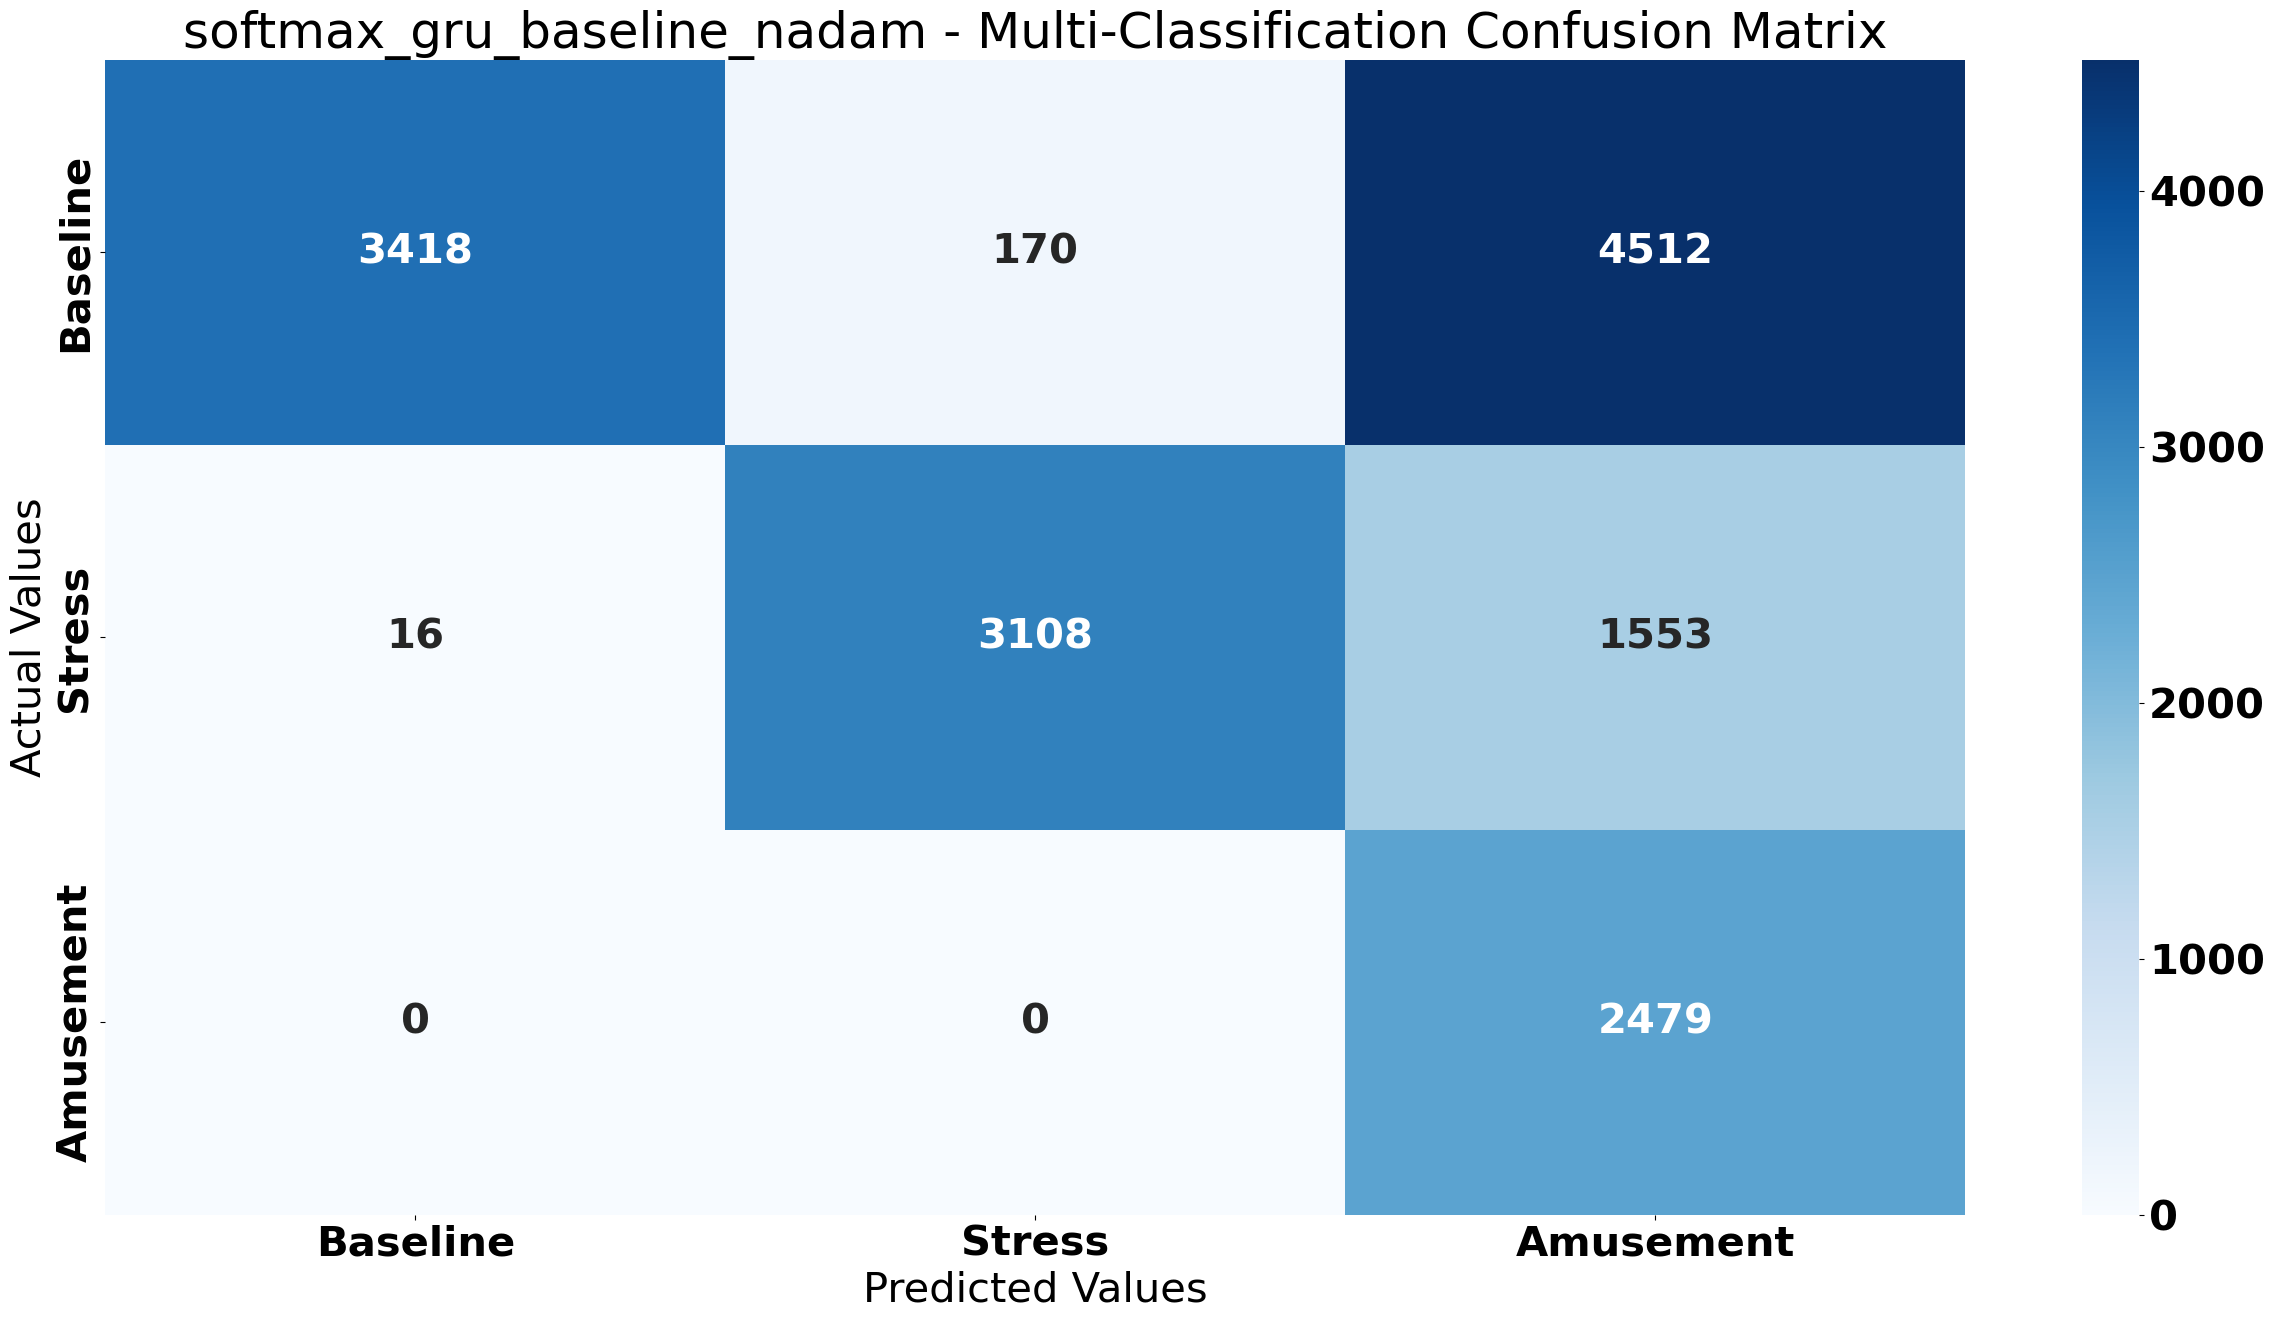

Classification Report: 

              precision    recall  f1-score   support

    Baseline       1.00      0.42      0.59      8100
      Stress       0.95      0.66      0.78      4677
   Amusement       0.29      1.00      0.45      2479

    accuracy                           0.59     15256
   macro avg       0.74      0.70      0.61     15256
weighted avg       0.87      0.59      0.63     15256

Matthews Correlation: 0.5287626964785881
############### END MODEL softmax_gru_baseline_nadam ###############
############### START MODEL softmax_gru_baseline_rmsprop ###############


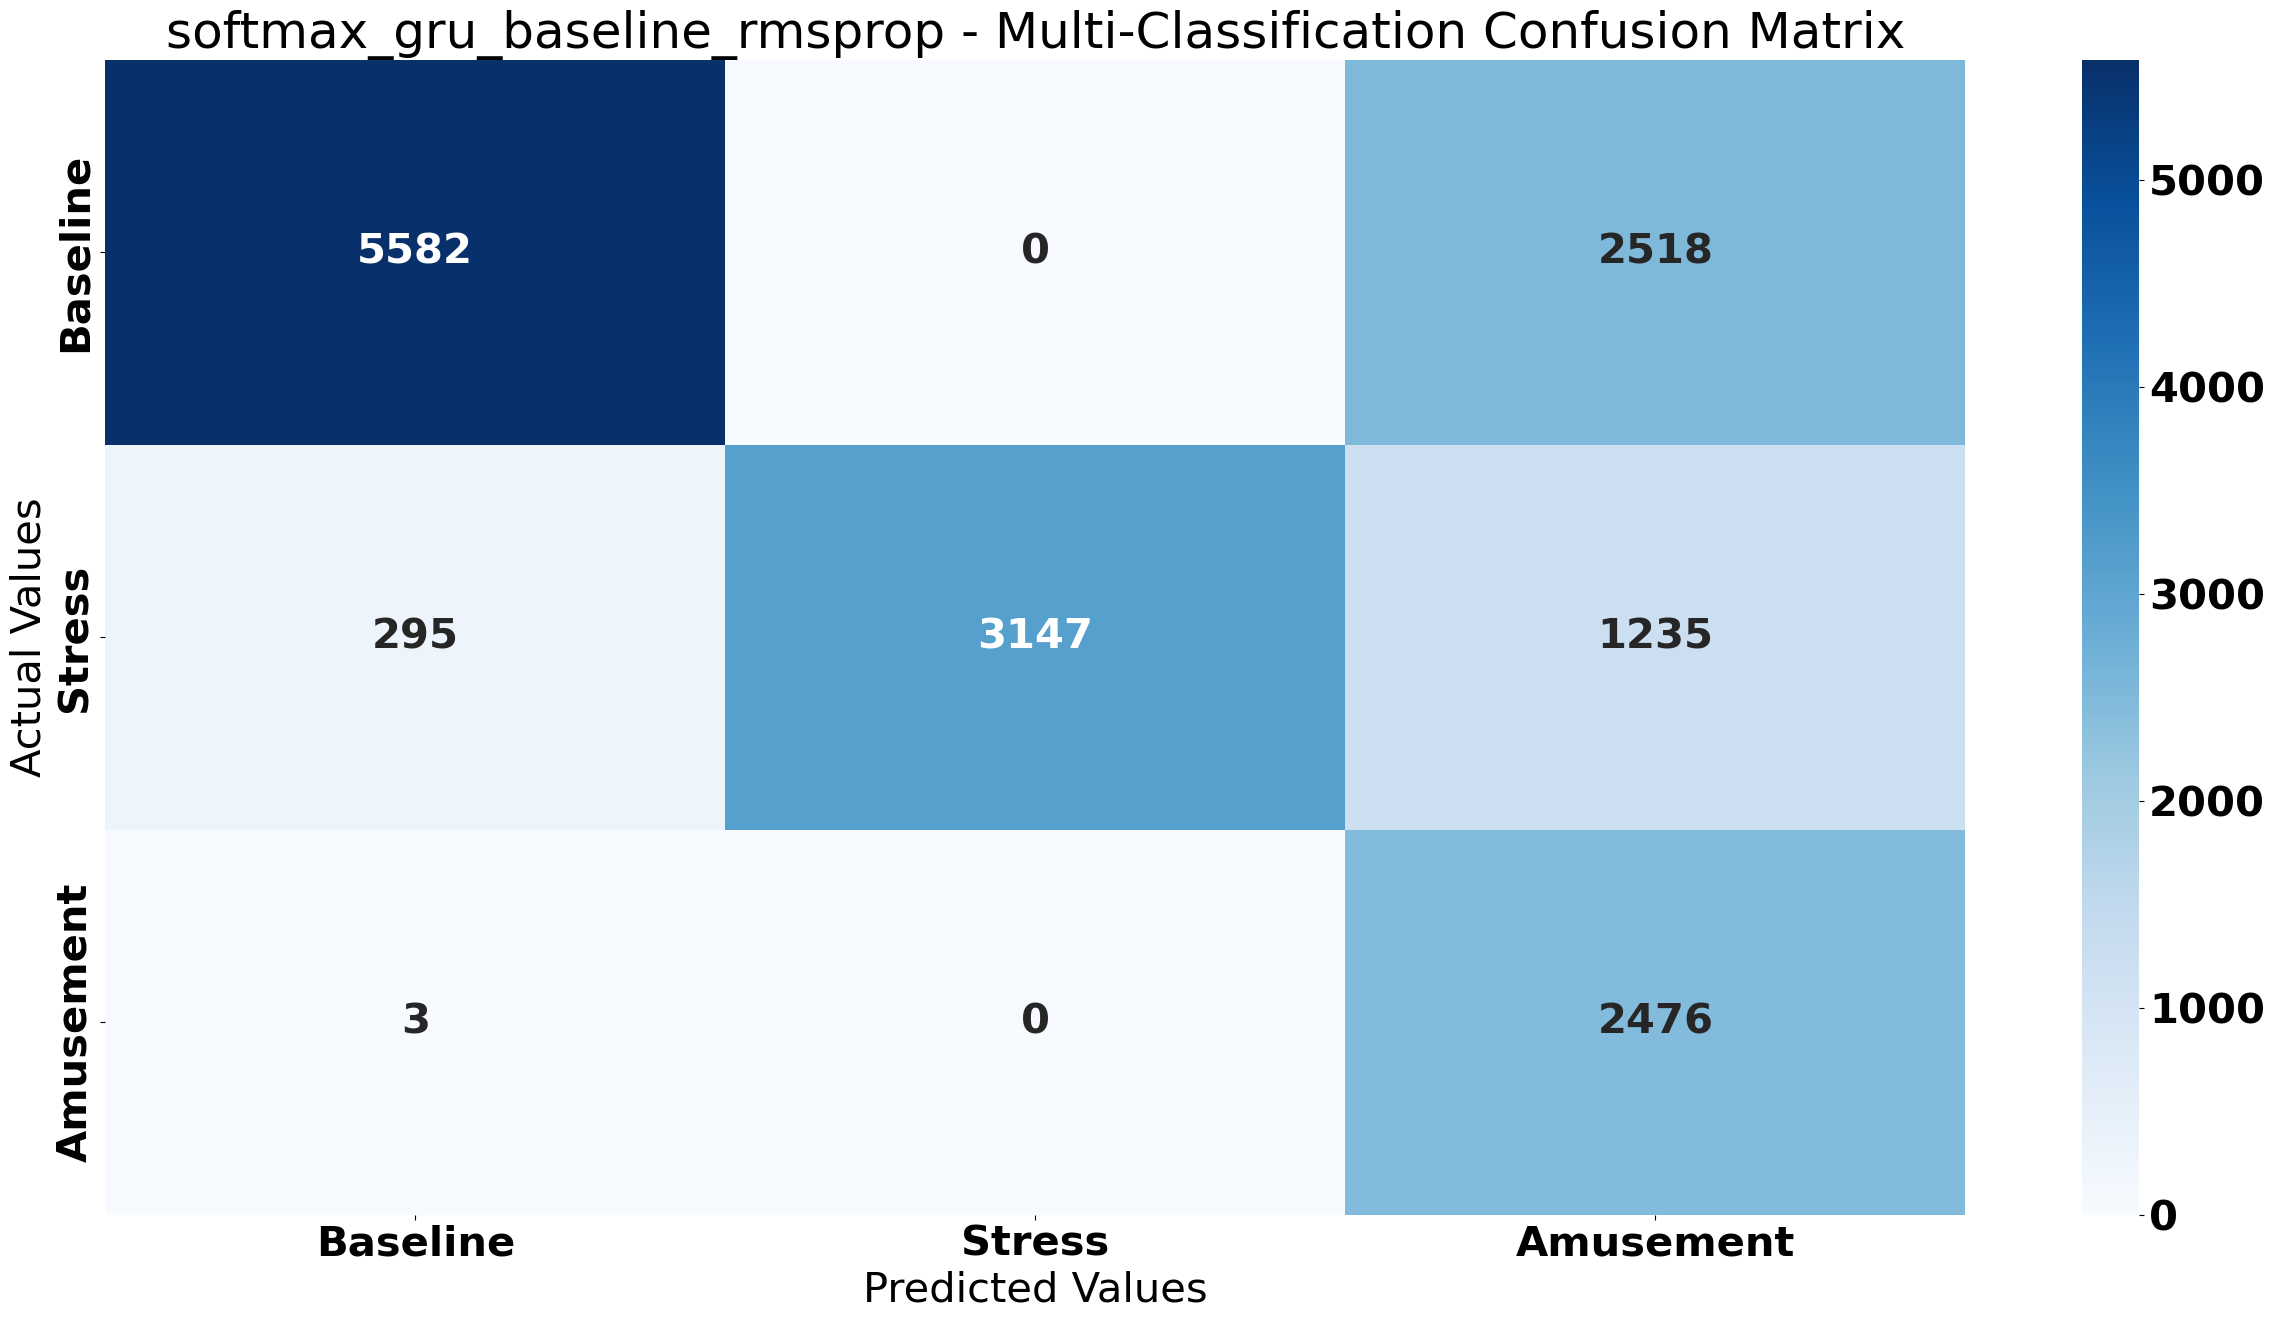

Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.95      0.69      0.80      8100
      Stress       1.00      0.67      0.80      4677
   Amusement       0.40      1.00      0.57      2479

    accuracy                           0.73     15256
   macro avg       0.78      0.79      0.72     15256
weighted avg       0.88      0.73      0.76     15256

Matthews Correlation: 0.6460207526451897
############### END MODEL softmax_gru_baseline_rmsprop ###############


In [37]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = validation_targets

for model_name in models_to_test:
    
    y_pred_prob = models_to_test[model_name]["model"].predict( x = convert_to_tensor(validation_features) )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    cm = confusion_matrix(df_y["y_test"].to_list(), df_y["y_pred"].to_list())
    cm_df = pd.DataFrame(cm, index = labels, columns = labels)
    
    print(f"############### START MODEL {model_name} ###############")

    plt.figure(figsize=(30,15))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f'{model_name} - Multi-Classification Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    print(f'Classification Report: \n\n{classification_report(df_y["y_test"], df_y["y_pred"], target_names=labels)}')
    print(f'Matthews Correlation: {matthews_corrcoef(df_y["y_test"], df_y["y_pred"])}')
    
    print(f"############### END MODEL {model_name} ###############")